In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re
import pprint
import numpy as np
#from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModelForSequenceClassification
import seaborn as sns
import json
import warnings
from scipy import stats
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.feature_selection import f_regression, mutual_info_regression
from itertools import combinations
from functions_analysis import *
import statsmodels.api as sm
from scipy.stats import f
# Suppress the specific FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
import locale
locale.setlocale(locale.LC_COLLATE, 'pl_PL.UTF-8')
import matplotlib.pyplot as plt
import seaborn as sns
import locale
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests

In [139]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)
pd.set_option('max_colwidth', 800)

# Dataset preparation

In [140]:
column_labels_pl = {
    # Stock columns
    'Otwarcie': 'Otwarcie',
    'Najwyzszy': 'Najwyższy kurs',
    'Najnizszy': 'Najniższy kurs',
    'Zamkniecie': 'Zamknięcie',
    'Wolumen': 'Wolumen',
    'Return': 'Zwrot',
    'volatility': 'Zmienność',
    'Direction': 'Kierunek',
    'Change': 'Zmiana (%)',

    # Tweet columns
    'Negative': 'Neg. tweety',
    'Neutral': 'Neu. tweety',
    'Positive': 'Poz. tweety',
    'view_count_Negative': 'Wyświetl. - neg.',
    'view_count_Neutral': 'Wyświetl. - neu.',
    'view_count_Positive': 'Wyświetl. - poz.',
    'total_retweet_count': 'Łączna liczba retweetów',
    'retweet_count_Negative': 'Retweety - neg.',
    'retweet_count_Neutral': 'Retweety - neu.',
    'retweet_count_Positive': 'Retweety - poz.',
    'tweet_volume': 'Liczba tweetów',
    'sentiment_score': 'Sent.',
    'sentiment_score_views': 'Sent. (waż. wyśw.)',
    'total_views': 'Łączna liczba wyświetl.',
    'sentiment_polarity': 'Polaryzacja sent.',
    'view_weighted_polarity': 'Polaryzacja (waż. wyśw.)',
    'sentiment_intensity': 'Intensywność sent.',
    'amplified_sentiment': 'Wzmocniony sent.',
    'sentiment_divergence': 'Rozbież. sent.',
    'engagement_impact': 'Wpływ zaangażowania',
}


In [141]:
# path = r'E:\Project_clean\PolishTweetsClassification\trained\1074368204844310350\checkpoint-808'
# model = AutoModelForSequenceClassification.from_pretrained(path)
# tokenizer = AutoTokenizer.from_pretrained("sdadas/polish-roberta-base-v2")

In [142]:
# df_processed = pd.read_csv('TrainingData/FINAL_TWEET_DATA_CLEANED.csv')
# df_processed['Date'] = pd.to_datetime(df_processed['created_at'], errors='coerce')
# df_processed =df_processed[~df_processed['text'].isna()]
# df_processed['sentiment_analysis'] = df_processed['text'].apply(lambda x: analyze_sentiment(text=x,tokenizer=tokenizer,model=model))
# df_processed[['sentiment', 'confidence']] = pd.DataFrame(df_processed['sentiment_analysis'].tolist())
# df_processed.to_csv('dataset2_analyzed.csv')
# df_processed.to_csv('dataset2_analyzed.csv')


In [143]:
# 1. Load the dataset
dataset_analyzed = pd.read_csv('dataset2_analyzed.csv')

# 2. Drop unwanted columns
columns = [col for col in dataset_analyzed.columns if col not in ['Unnamed: 0', 'Unnamed: 0.1']]
dataset_analyzed = dataset_analyzed[columns]

# 4. Parse 'created_at' as UTC datetime (handles tz-aware and tz-naive values safely)
dataset_analyzed['created_at'] = pd.to_datetime(dataset_analyzed['created_at'], errors='raise', utc=True)

# 5. Convert to Warsaw time
dataset_analyzed['created_at'] = dataset_analyzed['created_at'].dt.tz_convert('Europe/Warsaw')

# 6. Create 'Date' column (date only, no time, tz-naive)
dataset_analyzed['Date'] = dataset_analyzed['created_at'].dt.normalize().dt.tz_localize(None)

dates_to_remove = [
    pd.Timestamp('2022-12-31 00:00:00'),
    pd.Timestamp('2024-01-01 00:00:00')
]

dataset_analyzed = dataset_analyzed[~dataset_analyzed['Date'].isin(dates_to_remove)]


In [144]:
dataset_analyzed.loc[:,'company'] = dataset_analyzed['company'].apply(lambda x: x.upper())

In [145]:
dataset_analyzed = dataset_analyzed[~((dataset_analyzed['Date']<pd.Timestamp('2024-07-02 00:00:00')) & (dataset_analyzed['company']=='MENTZEN'))]
dataset_analyzed = dataset_analyzed[~((dataset_analyzed['Date']<pd.Timestamp('2024-10-17 00:00:00')) & (dataset_analyzed['company']=='ŻABKA'))]

In [146]:
dataset_analyzed[dataset_analyzed['company']=='ŻABKA'].sort_values(by='created_at', ascending=True)

,id,created_at,user_name,user_id,text,lang,in_reply_to,is_quote_status,quote_id,retweeted_tweet_id,possibly_sensitive,quote_count,reply_count,favorite_count,retweet_count,view_count,hashtags,urls,is_translatable,has_card,thumbnail_title,thumbnail_url,company,timestamp,agent,stock_company,Date,sentiment_analysis,sentiment,confidence
53795,1846970325801509233,2024-10-17 00:00:00+02:00,Michał,1824704480614445056,"@Radoslaw2202 hehe wtedy by się okazało że jednak te multikulti nie jest trakie fajne :D choć... choć... może być inny fikołek, że okaże się to był rodowity polak jak ten pod żabką! 🤡",pl,1.846589e+18,0,NaN,NaN,NaN,0,0,0,0,98.0,NaN,NaN,0.0,0,NaN,NaN,ŻABKA,2024-11-12 18:25:08.407289,@heniek36988,ZABKA,2024-10-17,"('Neutral', 0.8284210562705994)",Neutral,0.828421
53898,1846865778844237969,2024-10-17 00:00:00+02:00,Maksymilian Kuch,1790327975491088384,"#ZAB lekko odbija przy RSI zbliżającym się do poziomu wyprzedania. Jeśli jednak kurs pozostanie dłużej poniżej 23,6% zniesienia Fibonacciego, może to oznaczać słabość popytu. #Zabka #IPO https://t.co/dk6XHKkvLZ",pl,NaN,0,NaN,NaN,0.0,4,25,9,1,34118.0,"ZAB,Zabka,IPO",NaN,0.0,0,NaN,NaN,ŻABKA,2024-11-12 18:30:05.259231,@heniek36988,ZABKA,2024-10-17,"('Negative', 0.7082975506782532)",Negative,0.708298
53899,1846865706693919202,2024-10-17 00:00:00+02:00,Arek Z,1196890160291553281,@Jakub_moscicki @UnfairValue1 No przy tych wysokich blokach to nie jest głupi pomysł jedna żabka na parterze dla plebsu z ulicy a 2 na 10 piętrze dla mieszkańców. Pogadam ze znajomym deweloperem bo mają straszną pizdę z lokalami komercyjnymi 😀,pl,1.846864e+18,0,NaN,NaN,NaN,0,0,0,0,80.0,NaN,NaN,0.0,0,NaN,NaN,ŻABKA,2024-11-12 18:30:05.262303,@heniek36988,ZABKA,2024-10-17,"('Negative', 0.5989961624145508)",Negative,0.598996
53900,1846865572912300301,2024-10-17 00:00:00+02:00,SeasonalResearch,602550970,ŻABKA mówi sprawdzam kondycji GPW. \r\n\r\n#ZAB #ZABKA,pl,NaN,0,NaN,NaN,NaN,0,0,6,0,697.0,"ZAB,ZABKA",NaN,0.0,0,NaN,NaN,ŻABKA,2024-11-12 18:30:05.277926,@heniek36988,ZABKA,2024-10-17,"('Neutral', 0.8648157119750977)",Neutral,0.864816
53901,1846865314530705810,2024-10-17 00:00:00+02:00,RM,331198493,"@PawelBiedrzycki @GPW_WSExchange To teraz program ""Żabka w portfelu"" jak Orlen i hotdogi z rabzrobiła dobrą robotęm ;)",pl,1.846813e+18,0,NaN,NaN,NaN,0,0,1,0,509.0,NaN,NaN,0.0,0,NaN,NaN,ŻABKA,2024-11-12 18:30:05.277926,@heniek36988,ZABKA,2024-10-17,"('Neutral', 0.862186849117279)",Neutral,0.862187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52398,1856788741731275165,2024-11-13 20:58:28+01:00,minnie,1064931728219885568,"@yizhuofei właśnie żabka! słyszałam, że czasem sprzedają ale n widziałam na oczy aż do dziś i jem i jest ok, nie urywa dupy ale dobre w miarę",pl,1.856788e+18,0,NaN,NaN,NaN,0,0,0,0,3.0,NaN,NaN,0.0,0,NaN,NaN,ŻABKA,2024-11-13 22:38:51.069043,@ojeciecwojtyla,ZABKA,2024-11-13,"('Neutral', 0.8557418584823608)",Neutral,0.855742
52397,1856791418494193995,2024-11-13 21:09:06+01:00,.nikola ⭐🌻 ¦ ⛦ chris obsessed ⛦,1465370769542758407,zabka habibi wez mnie do pracy potrzebuje zarobic pirniadze,pl,NaN,0,NaN,NaN,NaN,0,1,3,0,90.0,NaN,NaN,0.0,0,NaN,NaN,ŻABKA,2024-11-13 22:38:51.060847,@ojeciecwojtyla,ZABKA,2024-11-13,"('Neutral', 0.8994515538215637)",Neutral,0.899452
52396,1856799717121720467,2024-11-13 21:42:04+01:00,Imaghosta | 🌙,834823310,"@joinourcarnival Żabka była moją pierwszą myślą \r\nSprawdzę, dzięki!",pl,1.856799e+18,0,NaN,NaN,NaN,0,0,0,0,31.0,NaN,NaN,0.0,0,NaN,NaN,ŻABKA,2024-11-13 22:38:51.051848,@ojeciecwojtyla,ZABKA,2024-11-13,"('Neutral', 0.8016447424888611)",Neutral,0.801645
52395,1856803452577542652,2024-11-13 21:56:55+01:00,lucrecia,1477997132527321093,@Imaghosta żabka,pl,1.856799e+18,0,NaN,NaN,NaN,0,0,1,0,12.0,NaN,NaN,0.0,0,NaN,NaN,ŻABKA,2024-11-13 22:38:51.041721,@ojeciecwojtyla,ZABKA,2024-11-13,"('Neutral', 0.9023386836051941)",Neutral,0.902339


In [147]:
companies =  ['11BIT', 'ALLEGRO', 'CCC', 'CDR', 'INPOST', 'XTB', 'MENTZEN', 'ŻABKA']

In [148]:
#STOCK DATA PROCESSING
companies_stock_data = {}

for company in companies:
    df = pd.read_csv(f'Stock_data/{company}.csv')
    df['Data'] = pd.to_datetime(df['Data'])
    df.sort_values(by = 'Data')

    # Calculate returns and other metrics
    df['Return'] = df['Zamkniecie'].pct_change()
    df['Same_day_return'] = (df['Zamkniecie'] - df['Otwarcie'])/ df['Otwarcie']
    df['Overnight_return'] = (df['Zamkniecie'] - df['Otwarcie'].shift(1))/ df['Zamkniecie']
    df['Change'] = df['Zamkniecie'] - df['Zamkniecie'].shift(1)

    df['Direction'] = df['Return'].apply(lambda x: 1 if x >0 else -1 )
    

    df['volatility'] = (
    (df['Najwyzszy'] - df['Najnizszy']) / df['Otwarcie']
    ).where(df['Otwarcie'] != 0, 0)

    
    # Create a complete date range from the minimum to maximum date in the dataset
    date_range = pd.date_range(start=df['Data'].min(), 
                          end=df['Data'].max(), 
                          freq='D')  
    
    # Reindex with complete date range
    df = df.set_index('Data').reindex(date_range).reset_index()
    df = df.rename(columns={'index': 'Date'})
    df['Date'] = pd.to_datetime(df['Date'], errors='raise')
    df['weekday'] = df['Date'].dt.day_name()
    df['company'] = company
    df['is_trading_day'] = df['Zamkniecie'].notna()
    companies_stock_data[company] = df

In [149]:
# TWEET DATA PROCESSING
aggregations = {
    'view_count': 'sum', 
    'retweet_count': 'sum',
    'sentiment': 'count'
    }
grouped_metrics = dataset_analyzed.groupby(['company','Date', 'sentiment']).agg(aggregations).unstack().reset_index()
grouped_metrics = grouped_metrics.fillna(0)
# Rename columns for clarity
grouped_metrics.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in grouped_metrics.columns]
grouped_metrics = grouped_metrics.rename(columns = {'company_':'company','Date_':'Date','sentiment_Negative':'Negative',
                                                       'sentiment_Neutral':'Neutral','sentiment_Positive':'Positive'})
grouped_metrics['sentiment_score'] =grouped_metrics['Positive'] - grouped_metrics['Negative']
grouped_metrics['sentiment_score_views'] = grouped_metrics['view_count_Positive'] - grouped_metrics['view_count_Negative']
grouped_metrics['tweet_volume'] = grouped_metrics['Positive'] + grouped_metrics['Neutral'] + grouped_metrics['Negative']
grouped_metrics['total_retweet_count'] =  grouped_metrics['retweet_count_Negative'] + grouped_metrics['retweet_count_Neutral'] + grouped_metrics['retweet_count_Positive']
grouped_metrics['total_views'] =  grouped_metrics['view_count_Negative'] + grouped_metrics['view_count_Neutral'] + grouped_metrics['view_count_Positive']
grouped_metrics['sentiment_polarity'] = (
        (grouped_metrics['Positive'] - grouped_metrics['Negative']) / 
        (grouped_metrics['Positive'] + grouped_metrics['Negative'])
    ).where(
        (grouped_metrics['Positive'] + grouped_metrics['Negative']) != 0, 
        0
    ) 

grouped_metrics['view_weighted_polarity'] = (
    (grouped_metrics['view_count_Positive'] - grouped_metrics['view_count_Negative']) / 
    grouped_metrics['total_views'].replace(0, 1)
)
grouped_metrics['sentiment_polarity_impact'] = grouped_metrics.apply(
    lambda row: row['sentiment_polarity'] * row['view_count_Positive'] if row['sentiment_polarity'] > 0
    else (row['sentiment_polarity'] * row['view_count_Negative'] if row['sentiment_polarity'] < 0 else 0),
    axis=1
)

# Virality coefficient
grouped_metrics['retweet_virality'] = grouped_metrics['total_retweet_count'] / grouped_metrics['total_views'].replace(0, 1)

# View dominance
grouped_metrics['negative_view_share'] = grouped_metrics['view_count_Negative'] / grouped_metrics['total_views'].replace(0, 1)
grouped_metrics['positive_view_share'] = grouped_metrics['view_count_Positive'] / grouped_metrics['total_views'].replace(0, 1)

# Non-neutral sentiment concentration
grouped_metrics['sentiment_intensity'] = (grouped_metrics['Positive'] + grouped_metrics['Negative']) / grouped_metrics['tweet_volume']

# Amplified sentiment score
grouped_metrics['amplified_sentiment'] = grouped_metrics['sentiment_score'] * grouped_metrics['retweet_virality']

# Sentiment divergence index
grouped_metrics['sentiment_divergence'] = abs(grouped_metrics['positive_view_share'] - grouped_metrics['negative_view_share'])
grouped_metrics['engagement_impact'] = grouped_metrics['view_weighted_polarity'] * np.log1p(grouped_metrics['total_views'])

display(grouped_metrics.head())

,company,Date,view_count_Negative,view_count_Neutral,view_count_Positive,retweet_count_Negative,retweet_count_Neutral,retweet_count_Positive,Negative,Neutral,Positive,sentiment_score,sentiment_score_views,tweet_volume,total_retweet_count,total_views,sentiment_polarity,view_weighted_polarity,sentiment_polarity_impact,retweet_virality,negative_view_share,positive_view_share,sentiment_intensity,amplified_sentiment,sentiment_divergence,engagement_impact
0,11BIT,2024-01-02,0.0,9918.0,2796.0,0.0,0.0,0.0,0.0,2.0,4.0,4.0,2796.0,6.0,0.0,12714.0,1.0,0.219915,2796.0,0.000000,0.000000,0.219915,0.666667,0.000000,0.219915,2.078316
1,11BIT,2024-01-03,0.0,512.0,6210.0,0.0,0.0,0.0,0.0,2.0,4.0,4.0,6210.0,6.0,0.0,6722.0,1.0,0.923832,6210.0,0.000000,0.000000,0.923832,0.666667,0.000000,0.923832,8.142001
2,11BIT,2024-01-04,9312.0,672.0,0.0,6.0,0.0,0.0,4.0,4.0,0.0,-4.0,-9312.0,8.0,6.0,9984.0,-1.0,-0.932692,-9312.0,0.000601,0.932692,0.000000,0.500000,-0.002404,0.932692,-8.589014
3,11BIT,2024-01-06,0.0,210.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,210.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,11BIT,2024-01-08,0.0,86.0,3812.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,3812.0,4.0,0.0,3898.0,1.0,0.977937,3812.0,0.000000,0.000000,0.977937,0.500000,0.000000,0.977937,8.086051


In [150]:
max_min_dates = {}
for company in companies:
    filtered = grouped_metrics[grouped_metrics['company']== company]
    filtered['Date'].max()
    filtered['Date'].min()
    max_min_dates[company] = {
        'max_date': filtered['Date'].max(),
        'min_date': filtered['Date'].min()
    }
max_min_dates

{'11BIT': {'max_date': Timestamp('2024-10-15 00:00:00'),
  'min_date': Timestamp('2024-01-02 00:00:00')},
 'ALLEGRO': {'max_date': Timestamp('2023-12-31 00:00:00'),
  'min_date': Timestamp('2023-01-01 00:00:00')},
 'CCC': {'max_date': Timestamp('2023-12-30 00:00:00'),
  'min_date': Timestamp('2023-01-01 00:00:00')},
 'CDR': {'max_date': Timestamp('2023-12-31 00:00:00'),
  'min_date': Timestamp('2023-01-01 00:00:00')},
 'INPOST': {'max_date': Timestamp('2023-12-30 00:00:00'),
  'min_date': Timestamp('2023-01-01 00:00:00')},
 'XTB': {'max_date': Timestamp('2023-12-31 00:00:00'),
  'min_date': Timestamp('2023-01-01 00:00:00')},
 'MENTZEN': {'max_date': Timestamp('2024-08-31 00:00:00'),
  'min_date': Timestamp('2024-07-02 00:00:00')},
 'ŻABKA': {'max_date': Timestamp('2024-11-13 00:00:00'),
  'min_date': Timestamp('2024-10-17 00:00:00')}}

In [151]:
tweet_data = {}
for company in companies:
    df = grouped_metrics[grouped_metrics['company'] == company]

    date_range = pd.date_range(start=df['Date'].min(), 
                          end=df['Date'].max(), 
                          freq='D')  

    df = df.set_index('Date').reindex(date_range).reset_index()
    df = df.rename(columns={'index': 'Date'})
    df['Date'] = pd.to_datetime(df['Date'], errors='raise')
    df['company'].fillna(company, inplace=True)
    df.fillna(0, inplace=True)
    tweet_data[company] = df

In [152]:
companies_data_daily = {}
selected_columns = ['company', 'Date','weekday','is_trading_day' , 'Negative', 'Neutral', 'Positive', 'sentiment_score','sentiment_polarity', 'tweet_volume','view_count_Negative', 'view_count_Neutral', 'view_count_Positive','total_views','sentiment_score_views','view_weighted_polarity','total_retweet_count' ,'retweet_count_Negative', 'retweet_count_Neutral', 'retweet_count_Positive','sentiment_intensity','amplified_sentiment','sentiment_divergence','engagement_impact' ,'Otwarcie', 'Najwyzszy', 'Najnizszy', 'Zamkniecie', 'Wolumen','volatility', 'Return','Direction','Change']

for company, df in companies_stock_data.items():
    df_with_prices = pd.merge(tweet_data[company],df, left_on = ['Date','company'],right_on=['Date','company'],how='left')
    # CHOOSE COLUMNS
    df_with_prices = df_with_prices[selected_columns]
    companies_data_daily[company] = df_with_prices

In [153]:
stock_columns = ['Otwarcie', 'Najwyzszy', 'Najnizszy', 'Zamkniecie', 'Wolumen', 'Return','volatility','Direction','Change']
tweet_columns = [ 'Negative', 'Neutral', 'Positive','view_count_Negative', 'view_count_Neutral', 'view_count_Positive', 'total_retweet_count',
                 'retweet_count_Negative', 'retweet_count_Neutral', 'retweet_count_Positive',
                 'tweet_volume', 'sentiment_score', 'sentiment_score_views','total_views','sentiment_polarity','view_weighted_polarity','sentiment_intensity','amplified_sentiment','sentiment_divergence','engagement_impact']


In [ ]:
# Modelling precomputed lags turned out to be too complex, so we will not use it in the final analysis.
# companies_data_daily_final = {}
# for company, df in companies_data_daily.items():
# #     companies_data_daily_final[company] = create_prediction_lags(df, tweet_col=tweet_columns, max_lags=5)
# # companies_data_daily_final_full = pd.DataFrame()
# tweet_columns_with_lagged = [x for x in companies_data_daily_final['ALLEGRO'] if x.startswith(tuple(tweet_columns))]

In [166]:
companies_data_daily_final_full = pd.DataFrame()
for key, df in companies_data_daily.items():
    companies_data_daily_final_full = pd.concat([df,companies_data_daily_final_full])
    companies_data_daily_final_full.dropna(inplace=True)


In [167]:
companies_data_daily_final_full['is_trading_day'].all()

True

## Exploratory Analysis

In [168]:
corr = companies_data_daily_final_full[tweet_columns].corr()
corr_melted = pd.melt(corr.reset_index(), id_vars='index', var_name='variable', value_name='correlation')
correlated_variables = corr_melted[(corr_melted['correlation']>=0.80) & (corr_melted['index'] != corr_melted['variable'])].copy()
correlated_variables.sort_values(by='correlation', ascending=False, inplace = True)

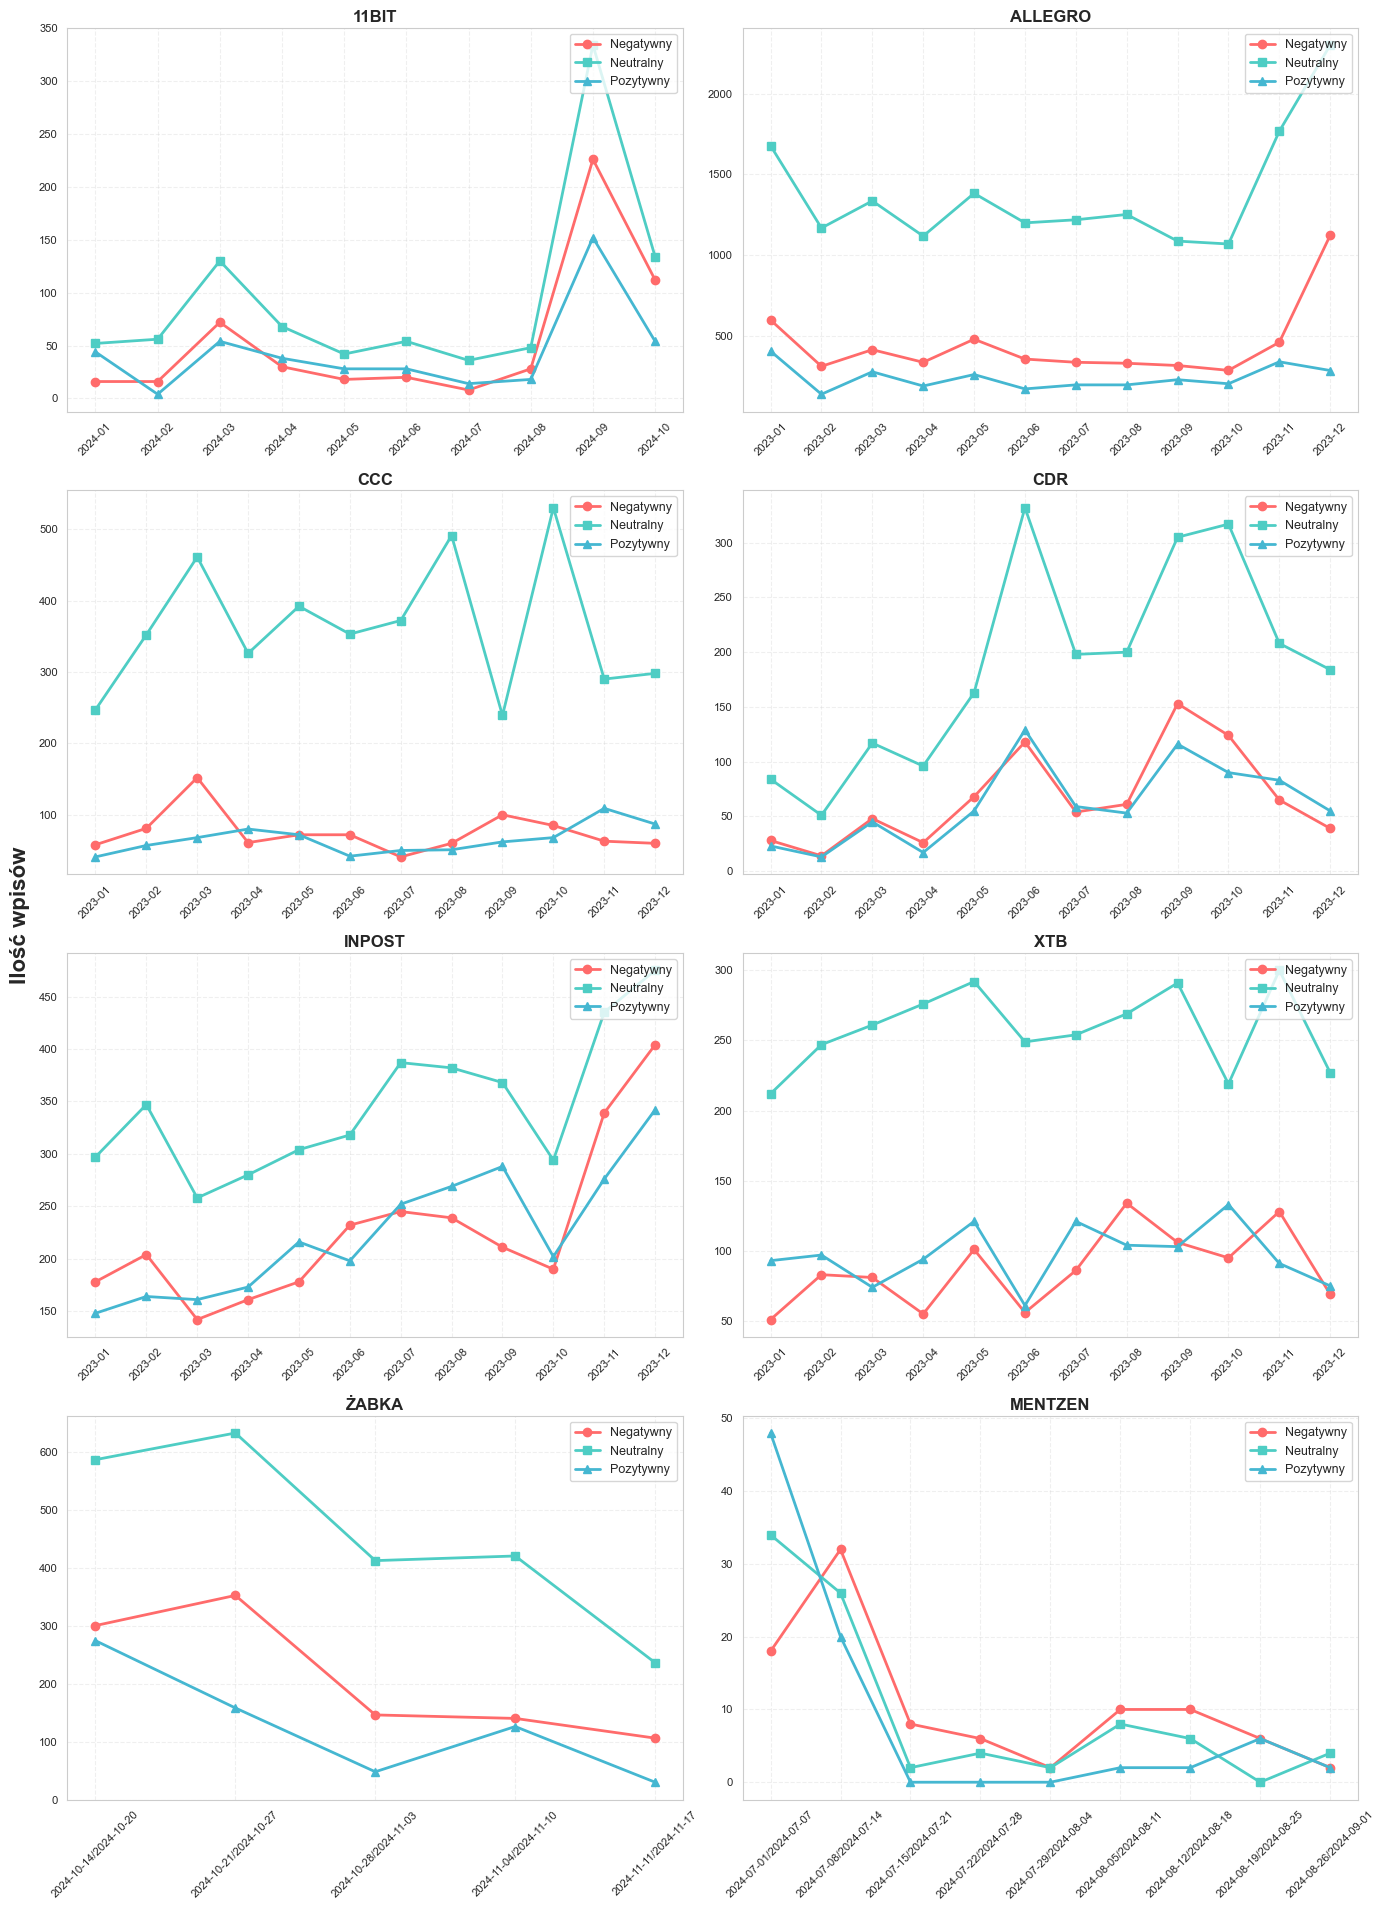

In [169]:
colors = {'Negative': '#FF6B6B', 'Neutral': '#4ECDC4', 'Positive': '#45B7D1'}
markers = {'Negative': 'o', 'Neutral': 's', 'Positive': '^'}
names = {'Negative': 'Negatywne',
         'Neutral': 'Neutralne',
         'Positive': 'Pozytywne'}

# Get company names and set fixed subplot layout
company_names = list(companies_data_daily.keys())

# Reorder companies: put zabka and mentzen at the end
weekly_companies = ['zabka', 'mentzen']
monthly_companies = [company for company in company_names 
                    if company.lower() not in [c.lower() for c in weekly_companies]]

# Create final ordered list with weekly companies last
ordered_companies = monthly_companies + [company for company in company_names 
                                       if company.lower() in [c.lower() for c in weekly_companies]]

n_companies = len(ordered_companies)

# Fixed layout: 2 columns and 4 rows
n_cols = 2
n_rows = 4

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(7*n_cols, 5*n_rows))

# Handle case where there's only one subplot
if n_companies == 1:
    axes = [axes]
elif n_rows == 1:
    axes = axes.reshape(1, -1)
elif n_cols == 1:
    axes = axes.reshape(-1, 1)

# Flatten axes array for easier iteration
axes_flat = axes.flatten()

for idx, company in enumerate(ordered_companies):
    df = companies_data_daily[company]
    company_data = df.copy()
    
    # Check if company should use weekly aggregation
    if company.lower() in ['żabka', 'mentzen']:
        # Weekly aggregation
        company_data['Week'] = company_data['Date'].dt.to_period('W')
        period_sentiment = company_data.groupby('Week').agg({
            'Negative': 'sum',
            'Neutral': 'sum', 
            'Positive': 'sum',
            'tweet_volume': 'sum',
            'total_views': 'sum'
        }).reset_index()
        x_values = period_sentiment['Week'].astype(str)
        period_label = 'Tydzień'
    else:
        # Monthly aggregation
        company_data['Month'] = company_data['Date'].dt.to_period('M')
        period_sentiment = company_data.groupby('Month').agg({
            'Negative': 'sum',
            'Neutral': 'sum', 
            'Positive': 'sum',
            'tweet_volume': 'sum',
            'total_views': 'sum'
        }).reset_index()
        x_values = period_sentiment['Month'].astype(str)
        period_label = 'Miesiąc'
    
    # Get current axis
    ax = axes_flat[idx]
    
    # Plot each sentiment line
    ax.plot(x_values, period_sentiment['Negative'], 
            color=colors['Negative'], marker=markers['Negative'],
            linewidth=2, label='Negatywny', markersize=6)
    
    ax.plot(x_values, period_sentiment['Neutral'], 
            color=colors['Neutral'], marker=markers['Neutral'],
            linewidth=2, label='Neutralny', markersize=6)
    
    ax.plot(x_values, period_sentiment['Positive'], 
            color=colors['Positive'], marker=markers['Positive'],
            linewidth=2, label='Pozytywny', markersize=6)
    
    # Customize each subplot
    ax.set_title(f'{company}', 
                fontsize=12, fontweight='bold', pad=4)
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Add grid
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Add legend
    ax.legend(fontsize=9, loc='upper right')
    
    # Rotate x-axis labels
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

# Hide empty subplots if any
for idx in range(n_companies, len(axes_flat)):
    axes_flat[idx].set_visible(False)

# Adjust layout
#plt.suptitle('Sentiment Analysis Dashboard', fontsize=16, fontweight='bold', y=0.98)

fig.text(0.01, 0.5, 'Ilość wpisów', 
         va='center', rotation='vertical', 
         fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0.02, 0, 1, 0.96])
# Show the plot



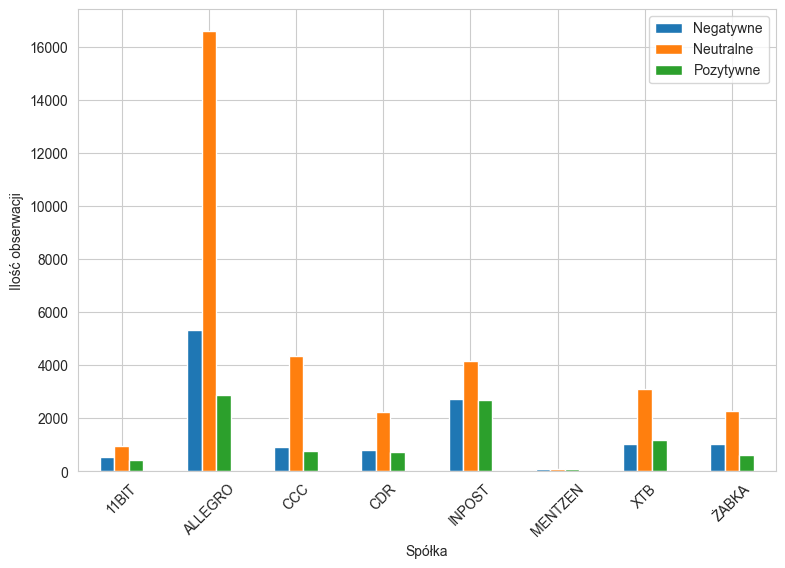

In [170]:
selected_columns = ['Negative','Neutral','Positive'] 
counts = grouped_metrics.groupby(['company'])[selected_columns].sum()

ax = counts.plot(kind='bar', figsize=(9, 6))
plt.xlabel('Spółka')
plt.ylabel('Ilość obserwacji')
plt.xticks(rotation=45)
ax.legend(['Negatywne', 'Neutralne', 'Pozytywne']) 
plt.show()


In [171]:
correlation_results = {}

for company in companies:
    correlation_results[company] = {}
    df = companies_data_daily_final_full[companies_data_daily_final_full['company'] == company]
    df_results = []  # Collect results for all lags
    x = df[stock_columns]
    y = df[tweet_columns]
    
    # Calculate correlation matrix
    corr_matrix = pd.concat([x, y], axis=1).corr()
    
    # Extract correlations between tweet_columns and stock_columns
    correlations = corr_matrix.loc[tweet_columns, stock_columns].reset_index()
    correlations = correlations.melt(id_vars='index', var_name='pair', value_name=f'Correlation')
    correlations['Correlation'] = correlations['Correlation'].round(2)
    df_results.append(correlations)
    
    # Combine all lag correlation results
    df_combined = df_results[0]
    df_combined = df_combined.sort_values('Correlation', key=lambda x: abs(x), ascending=False)
    correlation_results[company] = df_combined
    
    print(company)
    #display(df_combined.head())


11BIT
ALLEGRO
CCC
CDR
INPOST
XTB
MENTZEN
ŻABKA


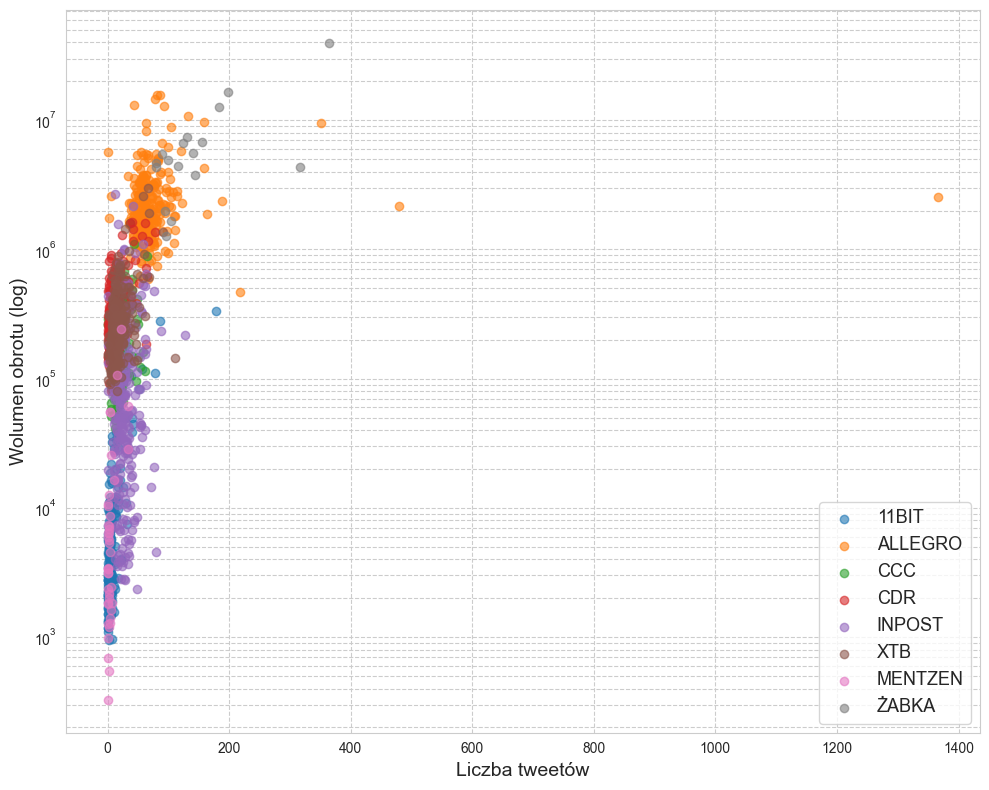

In [172]:
plt.figure(figsize=(10, 8))
for company in companies:
    company_data = companies_data_daily_final_full[companies_data_daily_final_full['company'] == company]
    plt.scatter(company_data['tweet_volume'], company_data['Wolumen'], 
                alpha=0.6, label=company)

#plt.title('Aktywność tweetów vs wolumen obrotu')
plt.xlabel('Liczba tweetów', fontsize=14)
plt.ylabel('Wolumen obrotu (log)',fontsize=14)
plt.yscale('log')
plt.legend(fontsize=13)
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

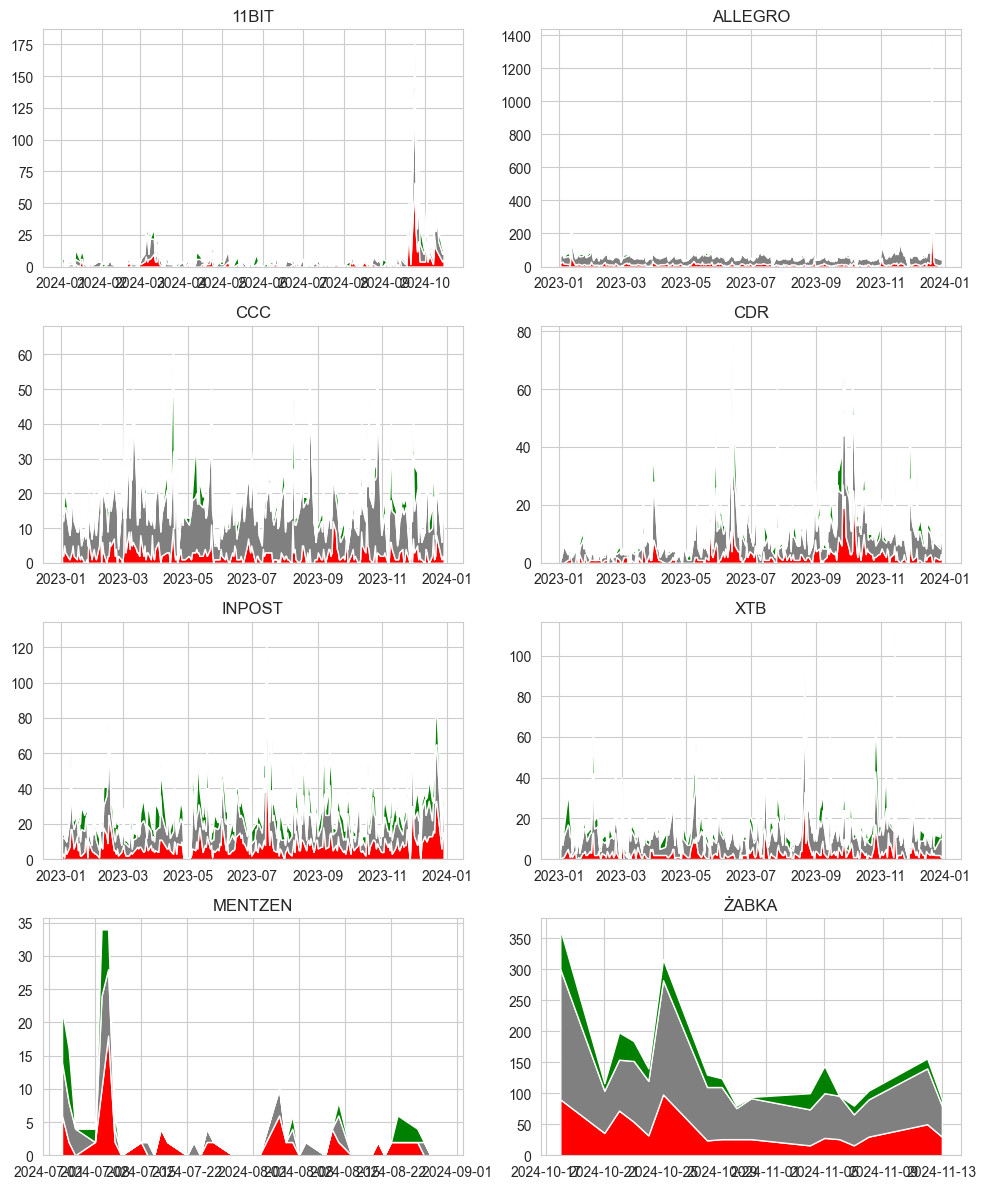

In [178]:
plt.figure(figsize=(10, 6))
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 12))
axes = axes.flatten()
for i, company in enumerate(companies):
    df = companies_data_daily_final_full[companies_data_daily_final_full['company'] == company].copy()

    dates = df['Date']
    negative = df['Negative']
    neutral = df['Neutral']
    positive = df['Positive']

    axes[i].stackplot(dates, negative, neutral, positive, 
                  labels=['Negatywne', 'Neutralne', 'Pozytywne'],
                  colors=['red', 'gray', 'green'])

    axes[i].set_title(company)
plt.tight_layout()
   

<Figure size 1000x600 with 0 Axes>

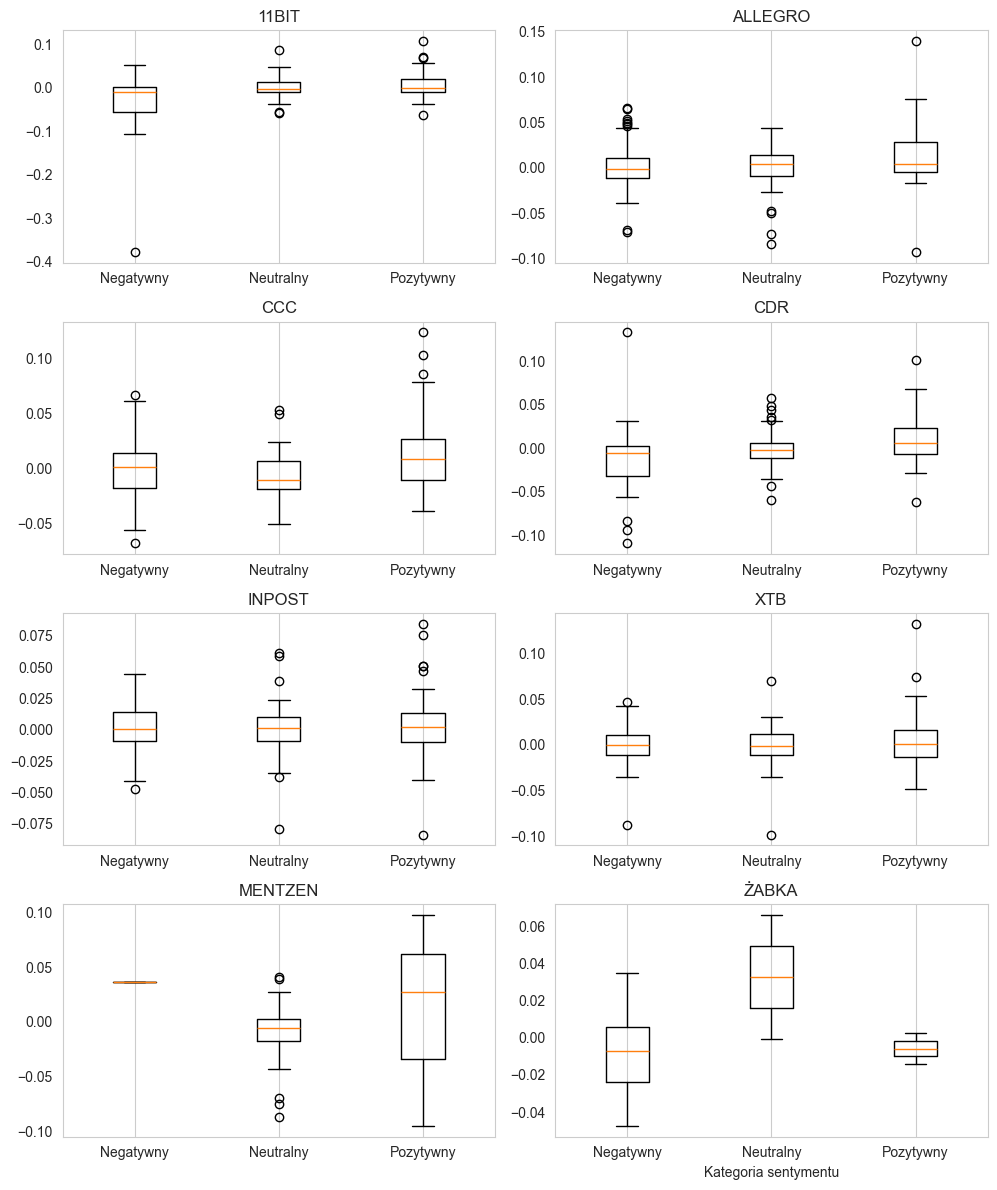

In [ ]:
plt.figure(figsize=(10, 6))
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 12))
axes = axes.flatten()
for i, company in enumerate(companies):
    df = companies_data_daily_final_full[companies_data_daily_final_full['company'] == company].copy()

    sentiment_labels = ['Negatywny', 'Neutralny', 'Pozytywny']
    bins = [-1, -0.1, 0.1, 1]  # Define sentiment polarity bins
    df.loc[:,'sentiment_category'] = pd.cut(df['sentiment_polarity'], 
                                                bins=bins, 
                                                labels=sentiment_labels)

    axes[i].boxplot([df[df['sentiment_category'] == cat]['Return'] for cat in sentiment_labels],
                labels=sentiment_labels)
    axes[i].set_title(company)
    axes[i].grid(axis='y')
    
    plt.xlabel('Kategoria sentymentu')
plt.tight_layout()
   

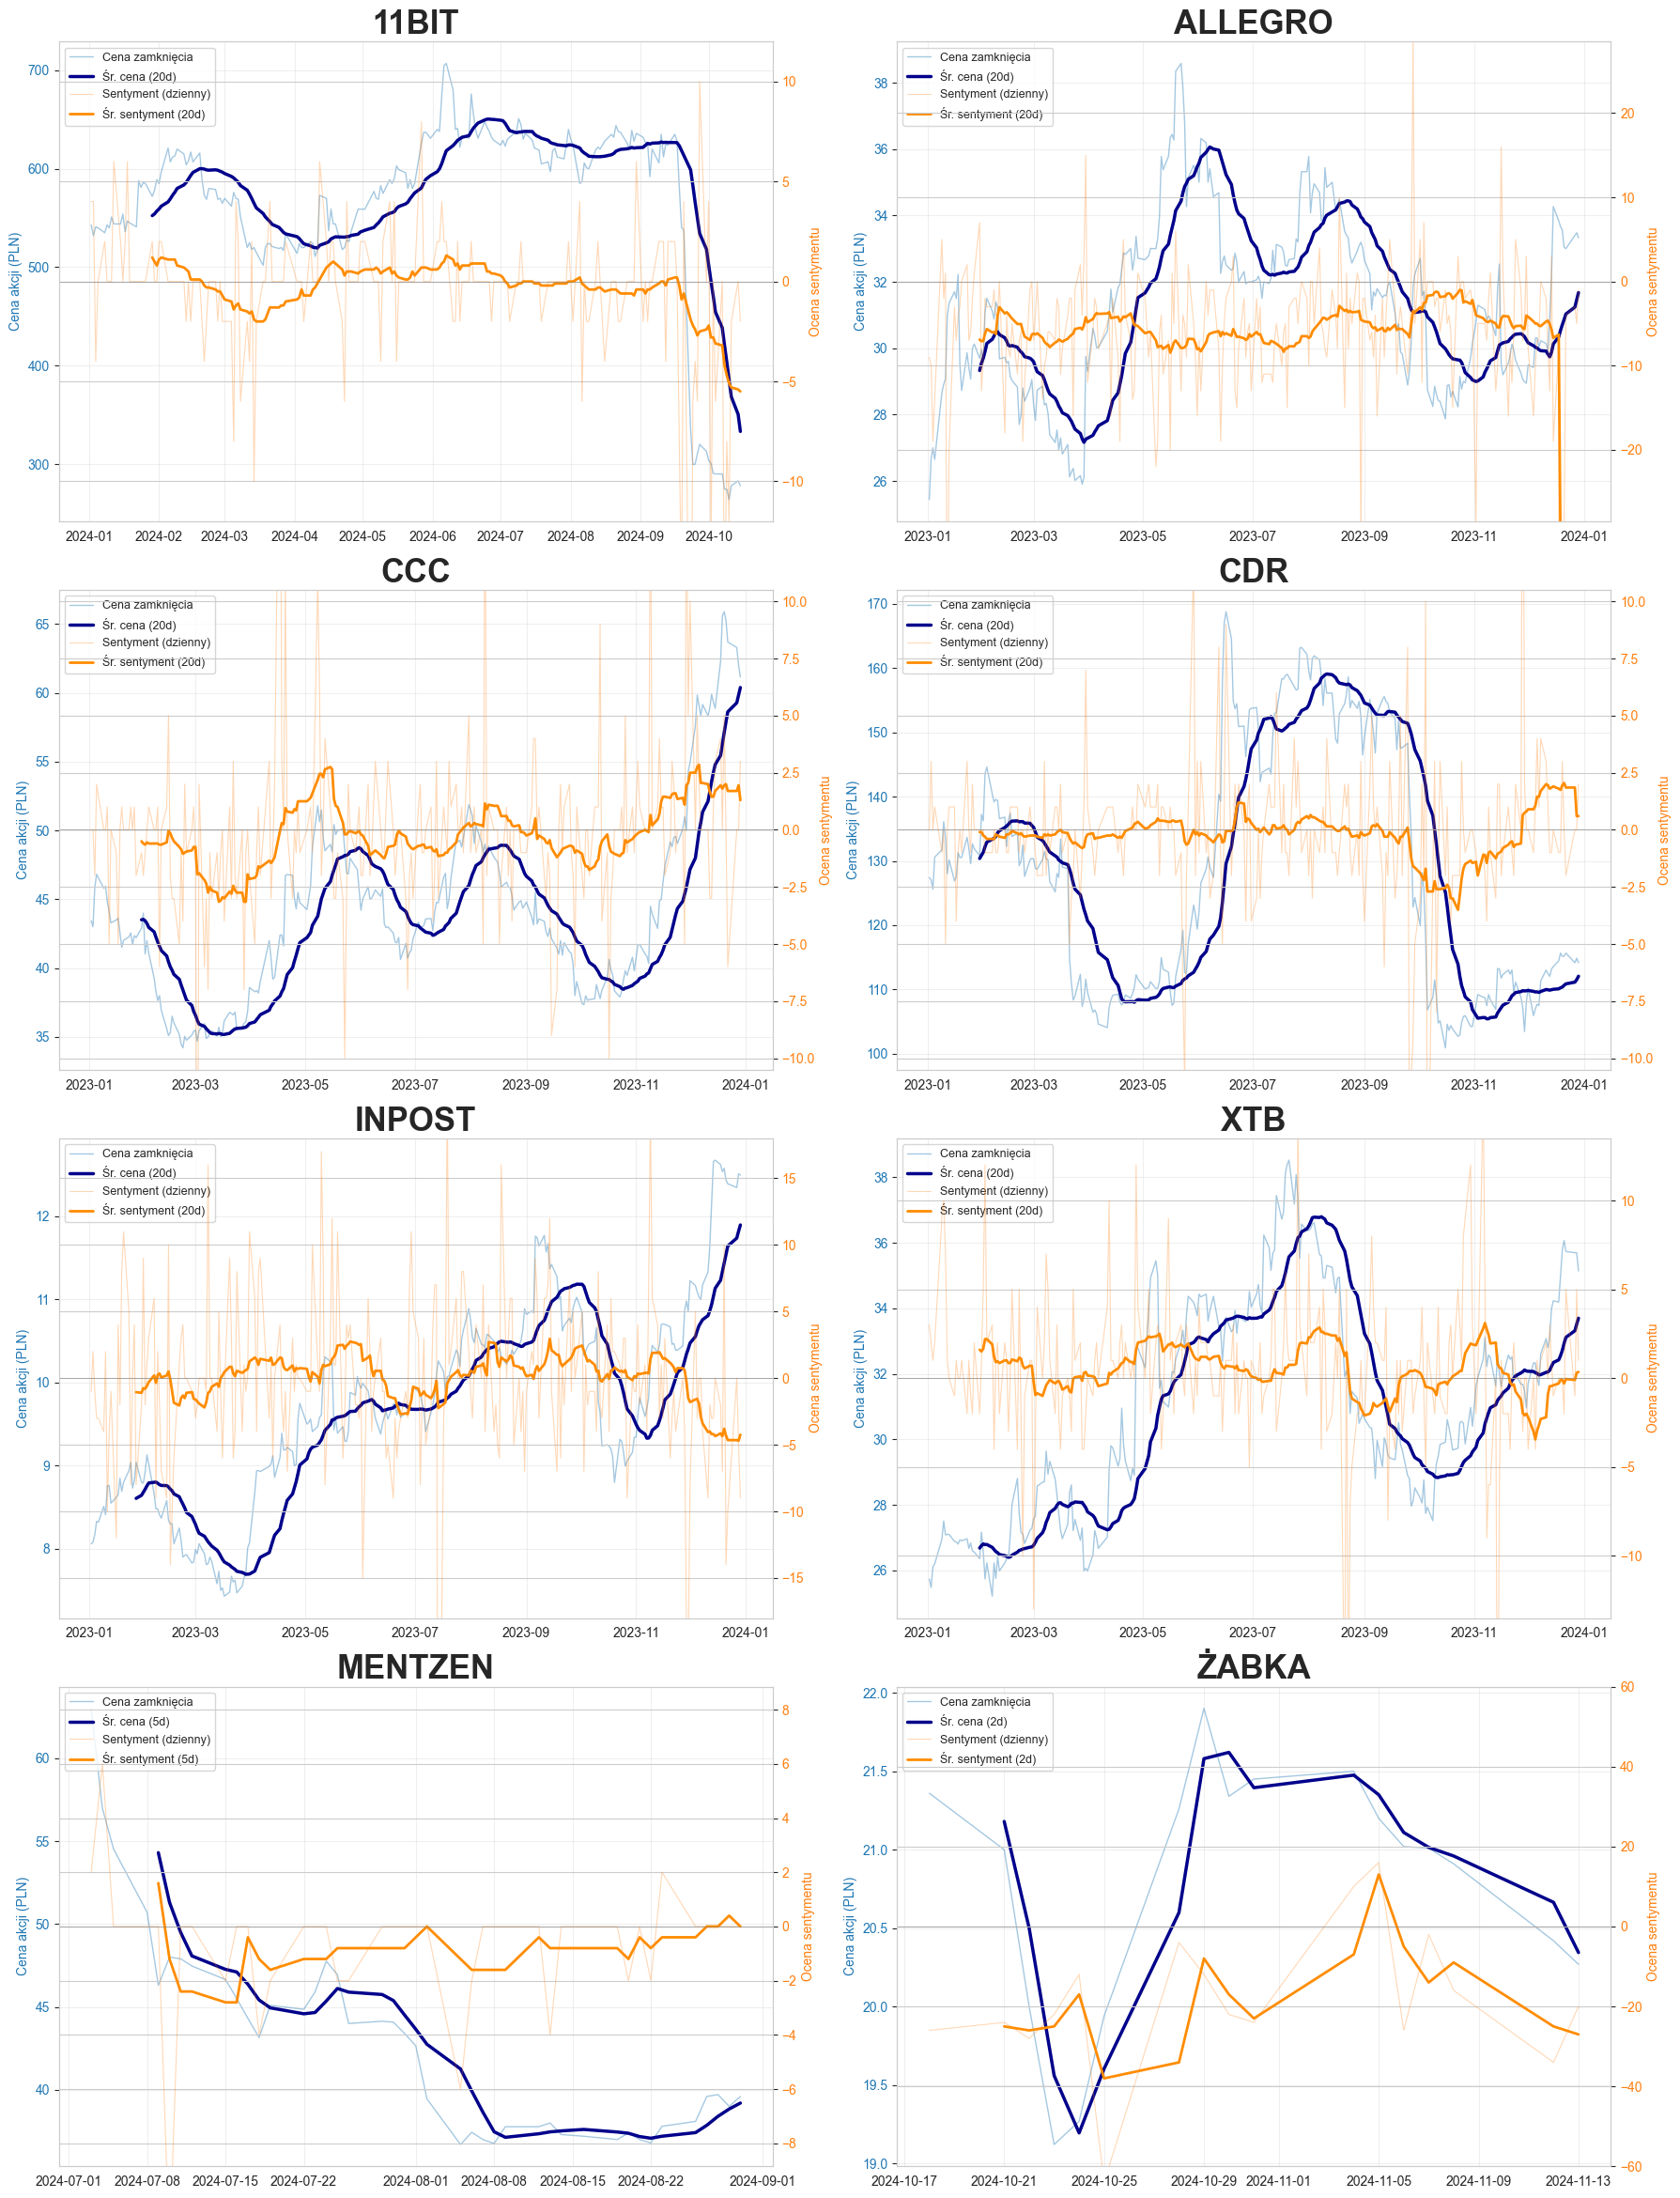

In [177]:
# Create 4x2 grid of subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(18, 25))
axes = axes.flatten()

# Default MA windows (used for non-special companies)
DEFAULT_PRICE_MA_WINDOW = 20
DEFAULT_SENTIMENT_MA_WINDOW = 20

# Special MA window configurations for ŻABKA and MENTZEN
SPECIAL_MA_WINDOWS = {
    "ŻABKA": {"price": 2, "sentiment": 2},  # Longer-term smoothing
    "MENTZEN": {"price": 5, "sentiment": 5}  # Shorter-term smoothing
}

for i, company in enumerate(companies):
    # Determine MA windows for this company
    if company in SPECIAL_MA_WINDOWS:
        price_window = SPECIAL_MA_WINDOWS[company]["price"]
        sentiment_window = SPECIAL_MA_WINDOWS[company]["sentiment"]
    else:
        price_window = DEFAULT_PRICE_MA_WINDOW
        sentiment_window = DEFAULT_SENTIMENT_MA_WINDOW

    # Filter company data
    df = companies_data_daily_final_full[companies_data_daily_final_full['company'] == company].copy()
    
    if df.empty:
        print(f"No data available for {company}, skipping...")
        axes[i].axis('off')
        continue
        
    # ---- STOCK PRICE AXIS ----
    ax1 = axes[i]
    ax1.plot(df['Date'], df['Zamkniecie'], color='tab:blue', linewidth=1.0, 
             alpha=0.4, label='Cena zamknięcia')
    
    # Use customized price MA window
    price_ma = df['Zamkniecie'].rolling(price_window).mean()
    ax1.plot(df['Date'], price_ma, color='darkblue', linewidth=2.5, 
             label=f'Śr. cena ({price_window}d)')
    
    ax1.set_ylabel('Cena akcji (PLN)', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_title(f'{company}', fontsize=25, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # ---- SENTIMENT AXIS ----
    ax2 = ax1.twinx()
    sentiment = df['sentiment_score'].dropna()
    
    if sentiment.empty:
        cap_value = 1.0
        ax2.set_ylabel('Brak danych sentymentu', color='tab:orange')
    else:
        ax2.plot(df['Date'], sentiment, color='tab:orange', linewidth=0.8, 
                 alpha=0.3, label='Sentyment (dzienny)')
        
        # Use customized sentiment MA window
        sentiment_ma = df['sentiment_score'].rolling(sentiment_window).mean()
        ax2.plot(df['Date'], sentiment_ma, color='darkorange', linewidth=2.0,
                 label=f'Śr. sentyment ({sentiment_window}d)')
        
        cap_value = np.percentile(np.abs(sentiment), 95) * 1.5
        ax2.set_ylabel('Ocena sentymentu', color='tab:orange')
    
    ax2.axhline(0, color='gray', linestyle='-', alpha=0.5, linewidth=0.7)
    ax2.set_ylim(-cap_value, cap_value)
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    
    # ---- LEGEND & FINAL TOUCHES ----
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=9)

# Add common labels and adjust layout
plt.xticks(rotation=45, ha='right')
plt.tight_layout(rect=[0, 0.03, 1, 0.97])

plt.show()

## Time Series Approach

### ADF test for stationarity

In [40]:
import numpy as np
from statsmodels.stats.diagnostic import acorr_ljungbox
import pprint
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import f

In [180]:
# Initialize results dictionaries
stationarity_results = {}

# Lists of variables
STOCK = stock_columns
TWITTER = tweet_columns

# Stationarity threshold
stationarity_p_threshold = 0.05  # p-value threshold for stationarity
# Check stationarity for each variable
for company in companies:
    stationarity_results[company] = {'STOCK': {}, 'TWITTER': {}}
    
    for variable in STOCK + TWITTER:
        # Extract data for the specific variable and company
        series = companies_data_daily_final_full[companies_data_daily_final_full['company'] == company][variable].dropna()
        
        # Perform the ADF test
        result = adfuller(series)
        p_value = result[1]
        
        # Store whether the variable is stationary
        category = 'STOCK' if variable in STOCK else 'TWITTER'
        stationarity_results[company][category][variable] = p_value < stationarity_p_threshold


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\statsmodels\regression\linear_model.py:957: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


In [181]:
stationary_columns = {}

for company, stock_tweet_res in stationarity_results.items():
    stationary_columns[company] = {'STOCK': [], 'TWITTER': []}
    for stock_tweet, res in stock_tweet_res.items():
        stationary = []
        for column, is_stationary in res.items():
            if is_stationary:
                stationary.append(column) 
        stationary_columns[company][stock_tweet] =  stationary

In [185]:
records = []
for company, categories in stationary_columns.items():
    for category, features in categories.items():
        for feature in features:
            records.append((company, category, feature))


df = pd.DataFrame(records, columns=['Company', 'Category', 'Feature'])
df['Feature'] = df['Feature'].replace(column_labels_pl)
df['Category'] = df['Category'].replace({'STOCK':'GIEŁDA'})

In [186]:
df_to_plot = df.groupby(['Company','Category']).count()
df_to_plot = df_to_plot.reset_index()

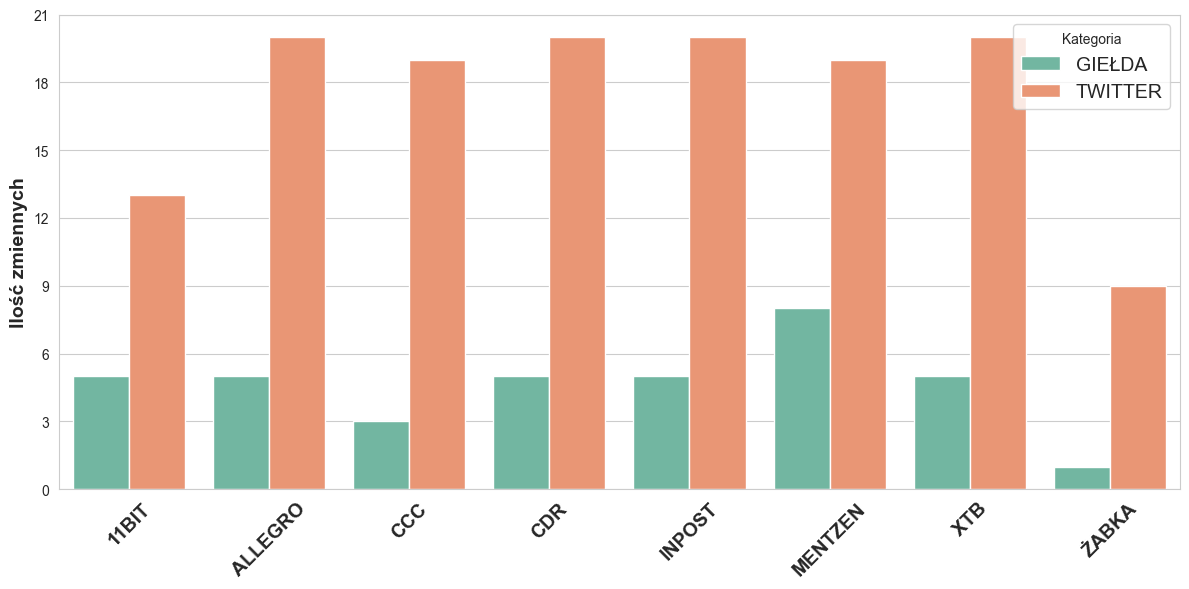

In [187]:
from matplotlib.ticker import MaxNLocator
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Create a grouped barplot
sns.barplot(data=df_to_plot, x='Company', y='Feature', hue='Category', palette='Set2')

# Force y-axis ticks to be integers
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

# Customize the plot
plt.ylabel('Ilość zmiennych',fontsize=14, fontweight = 'bold')
plt.xlabel('')
plt.xticks(rotation=45, fontsize = 14,fontweight = 'bold')
plt.legend(title='Kategoria', loc='upper right', fontsize=14)
plt.tight_layout()
plt.show()

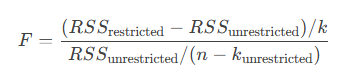

In [189]:

# Initialize results dictionaries
autocorrelation_results_ord = {}
autocorr_p_threshold = 0.05
max_lags = 20  # Increase to better detect order

# Check autocorrelation for each variable
for company in companies:
    STOCK = [k for k,v in stationarity_results[company]['STOCK'].items() if v]
    TWITTER = [k for k,v in stationarity_results[company]['TWITTER'].items() if v]
    autocorrelation_results_ord[company] = {'STOCK': {}, 'TWITTER': {}}
    
    for variable in STOCK + TWITTER:
        series = companies_data_daily_final_full[
            companies_data_daily_final_full['company'] == company
        ][variable].dropna()
        
        if len(series) <= max_lags:
            category = 'STOCK' if variable in STOCK else 'TWITTER'
            autocorrelation_results_ord[company][category][variable] = 1  # Default block size
            continue
        
        # Ljung-Box test for each lag
        ljung_box_result = acorr_ljungbox(series, lags=max_lags, return_df=True)
        p_values = ljung_box_result['lb_pvalue']
        
        # Find the order - last significant lag
        significant_lags = np.where(p_values < autocorr_p_threshold)[0]
        
        if len(significant_lags) == 0:
            autocorr_order = 0  # No autocorrelation, use block size 1
        else:
            autocorr_order = significant_lags[-1] + 1  # +1 because index starts at 0
        
        category = 'STOCK' if variable in STOCK else 'TWITTER'
        autocorrelation_results_ord[company][category][variable] = autocorr_order

print("AUTOCORRELATION ORDER (for block bootstrap):")
print("=" * 50)
pprint.pprint(autocorrelation_results_ord)

AUTOCORRELATION ORDER (for block bootstrap):
{'11BIT': {'STOCK': {'Change': 0,
                     'Direction': 20,
                     'Return': 0,
                     'Wolumen': 20,
                     'volatility': 20},
           'TWITTER': {'Positive': 20,
                       'amplified_sentiment': 0,
                       'engagement_impact': 0,
                       'retweet_count_Neutral': 20,
                       'sentiment_divergence': 0,
                       'sentiment_intensity': 3,
                       'sentiment_polarity': 17,
                       'sentiment_score_views': 3,
                       'total_views': 20,
                       'view_count_Negative': 20,
                       'view_count_Neutral': 20,
                       'view_count_Positive': 20,
                       'view_weighted_polarity': 0}},
 'ALLEGRO': {'STOCK': {'Change': 0,
                       'Direction': 1,
                       'Return': 0,
                       'Wolumen

In [99]:
def block_shuffle(series, block_size):
    """Shuffle blocks of a time series while preserving internal structure."""
    n = len(series)
    n_blocks = n // block_size
    blocks = [series[i*block_size:(i+1)*block_size].values for i in range(n_blocks)]
    
    # Handle remainder
    remainder = n % block_size
    if remainder > 0:
        blocks.append(series[n_blocks*block_size:].values)
    
    np.random.shuffle(blocks)
    return pd.Series(np.concatenate(blocks), index=series.index)

In [100]:

granger_results = {}
granger_p_threshold = 0.05
maxlag = 5  # Maximum lag order to test

for company, results in stationarity_results.items():
    granger_results[company] = {}
    
    # Get company-specific data
    df_company = companies_data_daily_final_full[companies_data_daily_final_full['company'] == company].copy()
    
    stationary_stock = stationary_columns[company]['STOCK']
    stationary_twitter = stationary_columns[company]['TWITTER']

    for stock_var in stationary_stock:
        granger_results[company][stock_var] = {}
        
        for twitter_var in stationary_twitter:
            significant_lags = {}
            
            # Create base dataset with current values
            base_cols = [stock_var] + [f"{twitter_var}_lag_{i}" for i in range(1, maxlag+1)]
            if not all(col in df_company.columns for col in base_cols):
                continue
                
            data = df_company[base_cols].copy()
            
            # Generate stock lags dynamically
            for lag in range(1, maxlag+1):
                data[f"{stock_var}_lag_{lag}"] = data[stock_var].shift(lag)
            
            # Test each lag order
            for p in range(1, maxlag+1):
                # Prepare required columns
                required_cols = [stock_var]
                stock_lags = [f"{stock_var}_lag_{i}" for i in range(1, p+1)]
                twitter_lags = [f"{twitter_var}_lag_{i}" for i in range(1, p+1)]
                
                # Skip if insufficient data
                test_data = data[required_cols + stock_lags + twitter_lags].dropna()
                n_obs = len(test_data)
                if n_obs < 2*p + 5:  # Ensure sufficient observations
                    continue
                
                # Prepare variables
                y = test_data[stock_var]
                X_restricted = test_data[stock_lags]
                X_unrestricted = test_data[stock_lags + twitter_lags]
                
                # Add constants
                X_restricted = sm.add_constant(X_restricted)
                X_unrestricted = sm.add_constant(X_unrestricted)
                
                try:
                    # Fit models
                    model_restricted = sm.OLS(y, X_restricted).fit()
                    model_unrestricted = sm.OLS(y, X_unrestricted).fit()
                    
                    # Calculate F-test
                    rss_r = model_restricted.ssr
                    rss_ur = model_unrestricted.ssr
                    n = n_obs
                    k = len(twitter_lags)  # Extra parameters
                    dfd = n - X_unrestricted.shape[1]  # Denominator DF
                    
                    if dfd <= 0:
                        continue
                    
                    F_stat = ((rss_r - rss_ur) / k) / (rss_ur / dfd)
                    p_value = 1 - f.cdf(F_stat, k, dfd)
                    
                    # Store significant results

                    significant_lags[p] = p_value
          
                except Exception as e:
                    continue  # Skip numerical errors
            
            # Store if significant lags found
            granger_results[company][stock_var][twitter_var] = {'significant_lagssignificant_lags': significant_lags}
granger_results

KeyboardInterrupt: 

In [ ]:
# New settings for bootstrap
bootstrap_block_size = 5  # Block size for shuffling
B = 2  # Number of bootstrap iterations

granger_results = {}
granger_p_threshold = 0.05
maxlag = 5

for company, results in stationarity_results.items():
    granger_results[company] = {}
    df_company = companies_data_daily_final_full[companies_data_daily_final_full['company'] == company].copy()
    
    stationary_stock = stationary_columns[company]['STOCK']
    stationary_twitter = stationary_columns[company]['TWITTER']


In [45]:
stationary_columns['CCC']

{'STOCK': ['Wolumen', 'volatility', 'Direction'],
 'TWITTER': ['Negative',
  'Neutral',
  'Positive',
  'view_count_Negative',
  'view_count_Neutral',
  'view_count_Positive',
  'total_retweet_count',
  'retweet_count_Negative',
  'retweet_count_Neutral',
  'tweet_volume',
  'sentiment_score',
  'sentiment_score_views',
  'total_views',
  'sentiment_polarity',
  'view_weighted_polarity',
  'sentiment_intensity',
  'amplified_sentiment',
  'sentiment_divergence',
  'engagement_impact']}

In [127]:
res = test_granger_bootstrap(companies_data_daily_final_full[companies_data_daily_final_full['company'] == 'CCC'],'volatility','Neutral',maxlag = 1, B = 1000, bootstrap_block_size = 3)

In [131]:
res['significant_lags']

{1: 0.147}

In [128]:
res['boot_res']

[{'lag_order': 1,
  'F_actual': 1.9602845428024556,
  'boot_F_stats': [3.320746660380537,
   1.1577613555357078,
   2.090613631136844,
   0.12539115128695247,
   0.044872192597433996,
   0.9943543509511654,
   0.004080085510889084,
   1.8928914273487765,
   0.30307660806389375,
   2.613124494760532,
   0.3842057688498477,
   0.006220501765219827,
   0.5921064083870942,
   0.048161537202653995,
   1.8357649699690273,
   0.3813629794990157,
   0.9639556242186159,
   0.01255036080162884,
   2.9025023294518384,
   0.2598311186555868,
   1.1355493279566844,
   0.07473734829805868,
   2.138361333318273e-05,
   0.01995718573668442,
   0.8243081907274804,
   0.7312590517424619,
   0.37239371497997403,
   2.6782159788824322,
   2.2642756544015112,
   2.6035702270536087,
   0.021168693418142277,
   0.36519505719655193,
   0.004608041665692821,
   2.8195859147730298,
   0.15756622942239432,
   0.12809602124938305,
   0.43852843316703616,
   0.3062938114637789,
   0.11943202938707466,
   0.0075653

<Axes: ylabel='Count'>

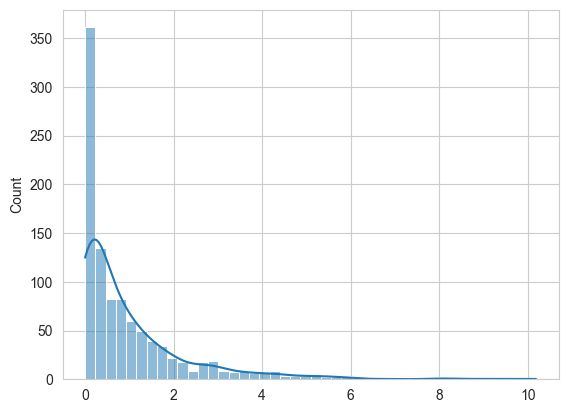

In [129]:
sns.histplot(res['boot_res'][0]['boot_F_stats'], kde=True)

In [130]:
np.mean(res['boot_res'][0]['boot_F_stats'])

0.9740903647481391

In [112]:
def test_granger_bootstrap(df, stock_var, twitter_var, maxlag, B, bootstrap_block_size):
    # Reset index to avoid label mismatch issues
    df = df.reset_index(drop=True).copy()
    dat = []
    significant_lags = {}
    base_cols = [stock_var] + [f"{twitter_var}_lag_{i}" for i in range(1, maxlag+1)]

    data = df[base_cols].copy()
    boot_res = []
    
    # Generate stock lags
    for lag in range(1, maxlag+1):
        data[f"{stock_var}_lag_{lag}"] = data[stock_var].shift(lag)
    
    # Test each lag order
    for p in range(1, maxlag+1):
        # Prepare data for current lag p
        required_cols = [stock_var]
        stock_lags = [f"{stock_var}_lag_{i}" for i in range(1, p+1)]
        twitter_lags = [f"{twitter_var}_lag_{i}" for i in range(1, p+1)]
        
        test_data = data[required_cols + stock_lags + twitter_lags].dropna()
        n_obs = len(test_data)
        if n_obs < 2*p + 5:
            continue
        
        # Split data
        y = test_data[stock_var]
        X_restricted = test_data[stock_lags]
        X_unrestricted = test_data[stock_lags + twitter_lags]
        
        # Add constants
        X_restricted = sm.add_constant(X_restricted)
        X_unrestricted = sm.add_constant(X_unrestricted)
        
        try:
            # Fit original models
            model_restricted = sm.OLS(y, X_restricted).fit()
            model_unrestricted = sm.OLS(y, X_unrestricted).fit()
            
            # Calculate actual F-statistic
            rss_r = model_restricted.ssr
            rss_ur = model_unrestricted.ssr
            k = len(twitter_lags)  # Extra parameters
            dfd = n_obs - X_unrestricted.shape[1]  # Denominator DF
            
            if dfd <= 0:
                continue
            
            F_actual = ((rss_r - rss_ur) / k) / (rss_ur / dfd)
            
            # Block bootstrap procedure
            count_exceeds = 0
            n_valid = 0
            idx = test_data.index
            
            # Initialize bootstrap results for this lag order
            boot_res_p = []
            
            for i in range(B):
                # Create block-shuffled Twitter series
                boot_twitter = block_shuffle(df[twitter_var], block_size=bootstrap_block_size)
                
                # Rebuild Twitter lags from shuffled series
                boot_twitter_lags = pd.DataFrame(index=df.index)
                for lag in range(1, p+1):
                    boot_twitter_lags[f"{twitter_var}_lag_{lag}"] = boot_twitter.shift(lag)
                
                # Align bootstrap data with test_data index
                boot_selected = boot_twitter_lags.loc[idx, twitter_lags].reset_index(drop=True)
                stock_selected = test_data[stock_lags].reset_index(drop=True)
                
                # Combine with original stock data
                X_unrestricted_boot = pd.concat([stock_selected, boot_selected], axis=1)
                dat.append(X_unrestricted_boot)
                X_unrestricted_boot = sm.add_constant(X_unrestricted_boot)
                
                # Skip iterations with insufficient data
                if X_unrestricted_boot.isnull().any().any():
                    continue
                
                try:
                    # Refit model with shuffled Twitter data
                    model_boot = sm.OLS(y.reset_index(drop=True), X_unrestricted_boot).fit()
                    rss_ur_boot = model_boot.ssr
                    
                    # Calculate bootstrap F-statistic
                    # FIXED: Use correct RSS values for F-statistic
                    F_boot = ((rss_r - rss_ur_boot) / k) / (rss_ur_boot / dfd)
                    boot_res_p.append(F_boot)
                    
                    if F_boot >= F_actual:
                        count_exceeds += 1
                    n_valid += 1
                  
                except Exception as e:
                    continue
            
            # Calculate bootstrap p-value
            p_value = count_exceeds / n_valid if n_valid > 0 else np.nan
            significant_lags[p] = p_value
            
            # Store bootstrap results for this specific lag order
            boot_res.append({
                'lag_order': p,
                'F_actual': F_actual,
                'boot_F_stats': boot_res_p,
                'p_value': p_value,
                'n_valid': n_valid,
                'count_exceeds': count_exceeds
            })
            
        except Exception as e:
            print(f"Error processing lag {p}: {str(e)}")
            continue
    
    return {
        'significant_lags': significant_lags,
        'boot_res': boot_res,
        'check': dat
    }

In [39]:
lb_test

,lb_stat,lb_pvalue
3,2.663775,0.446418


In [40]:
bp_test

(5.934783078351009, 0.4305352966181232, 0.8154123140492558, 0.6005280178340463)

In [39]:
df = flatten_granger_results(granger_results)
df['-log10(p)'] = -np.log10(df['P-Value'])  # Transform p-values
df['Significant'] = df['P-Value'] < 0.05     # Significance flag

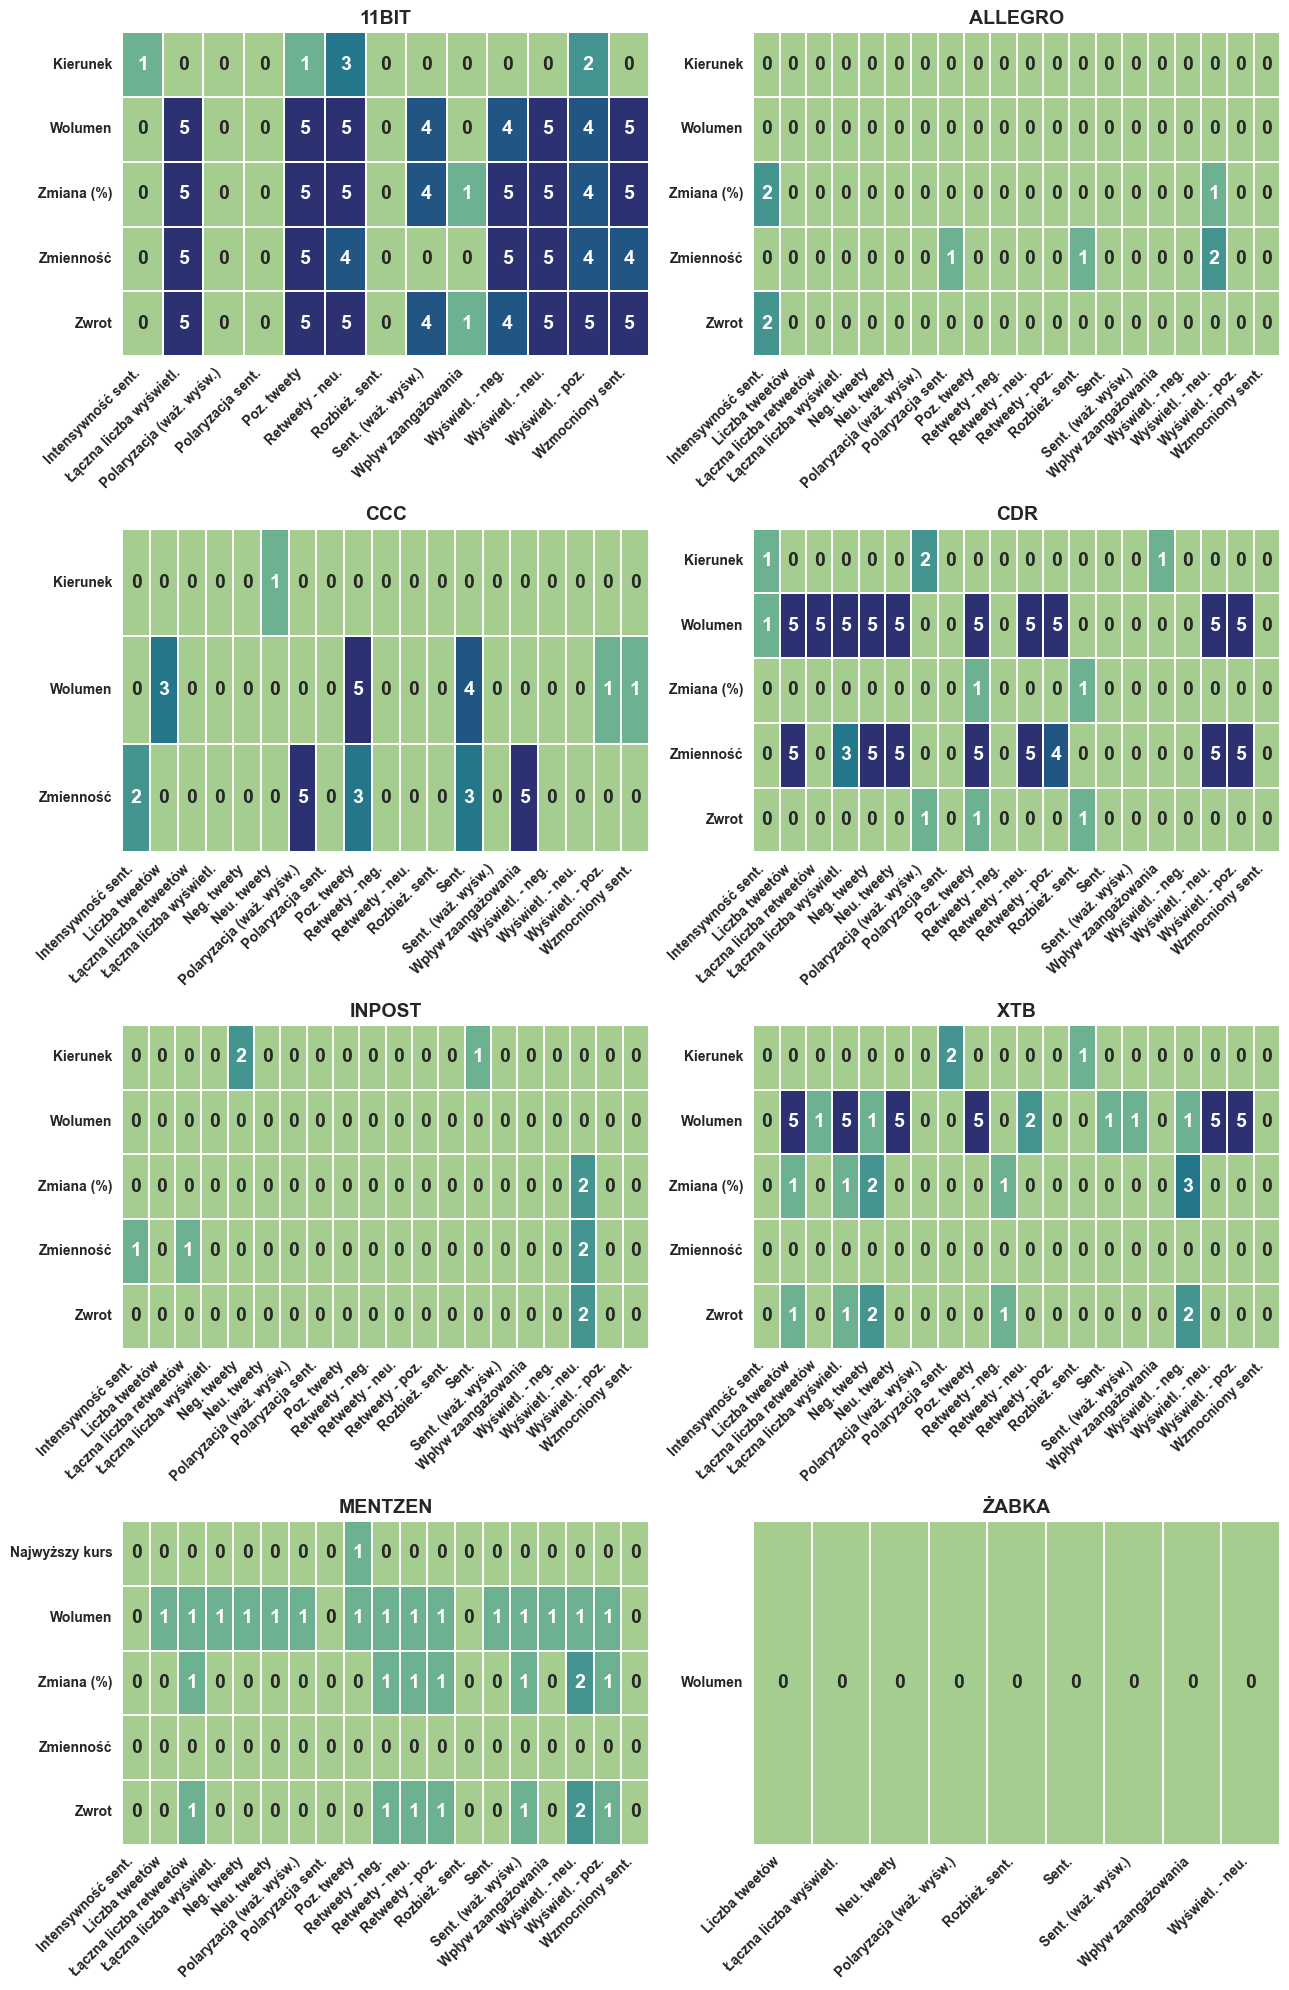

In [40]:
# Your df and column_labels_pl are assumed defined
df['Zmienne Objaśniana'] = df['Target Variable'].replace(column_labels_pl)
df['Zmienne Objaśniające'] = df['Source Feature'].replace(column_labels_pl)

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(13, 20))
axes = axes.flatten()

max_val = 0
pivot_tables = []

for company in companies:
    # Get company data (both significant and non-significant)
    company_data = df[df['Company'] == company]
    
    # Get unique variables from company's data
    row_labels = sorted(company_data['Zmienne Objaśniana'].dropna().unique(), key=locale.strxfrm)
    col_labels = sorted(company_data['Zmienne Objaśniające'].dropna().unique(), key=locale.strxfrm)
    
    # Handle case with no variables
    if len(row_labels) == 0:
        row_labels = ["-"]
    if len(col_labels) == 0:
        col_labels = ["-"]
    
    # Create pivot table for significant relationships
    company_sig = company_data[company_data['Significant']]
    pivot_table = company_sig.pivot_table(
        index='Zmienne Objaśniana',
        columns='Zmienne Objaśniające',
        values='Lag',
        aggfunc='count',
        fill_value=0
    ).reindex(index=row_labels, columns=col_labels, fill_value=0)
    
    pivot_tables.append(pivot_table)
    
    # Update max value for color scaling
    current_max = pivot_table.max().max()
    if current_max > max_val:
        max_val = current_max

# Handle case where all values are zero
if max_val == 0:
    max_val = 1  # Prevent color scale errors

# Plot each company's heatmap
for i, company in enumerate(companies):
    ax = axes[i]
    sns.heatmap(
        pivot_tables[i],
        annot=True,
        fmt='d',
        cmap='crest',
        linewidths=0.1,
        linecolor='white',
        vmin=0,
        vmax=max_val,
        cbar=False,
        ax=ax,
        annot_kws={"fontsize": 14, "weight": "bold"}
    )
    
    ax.set_title(company, fontsize=14, fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10, fontweight='bold')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right', fontsize=10, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

In [41]:
companies

['11BIT', 'ALLEGRO', 'CCC', 'CDR', 'INPOST', 'XTB', 'MENTZEN', 'ŻABKA']

e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\seaborn\matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\seaborn\matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


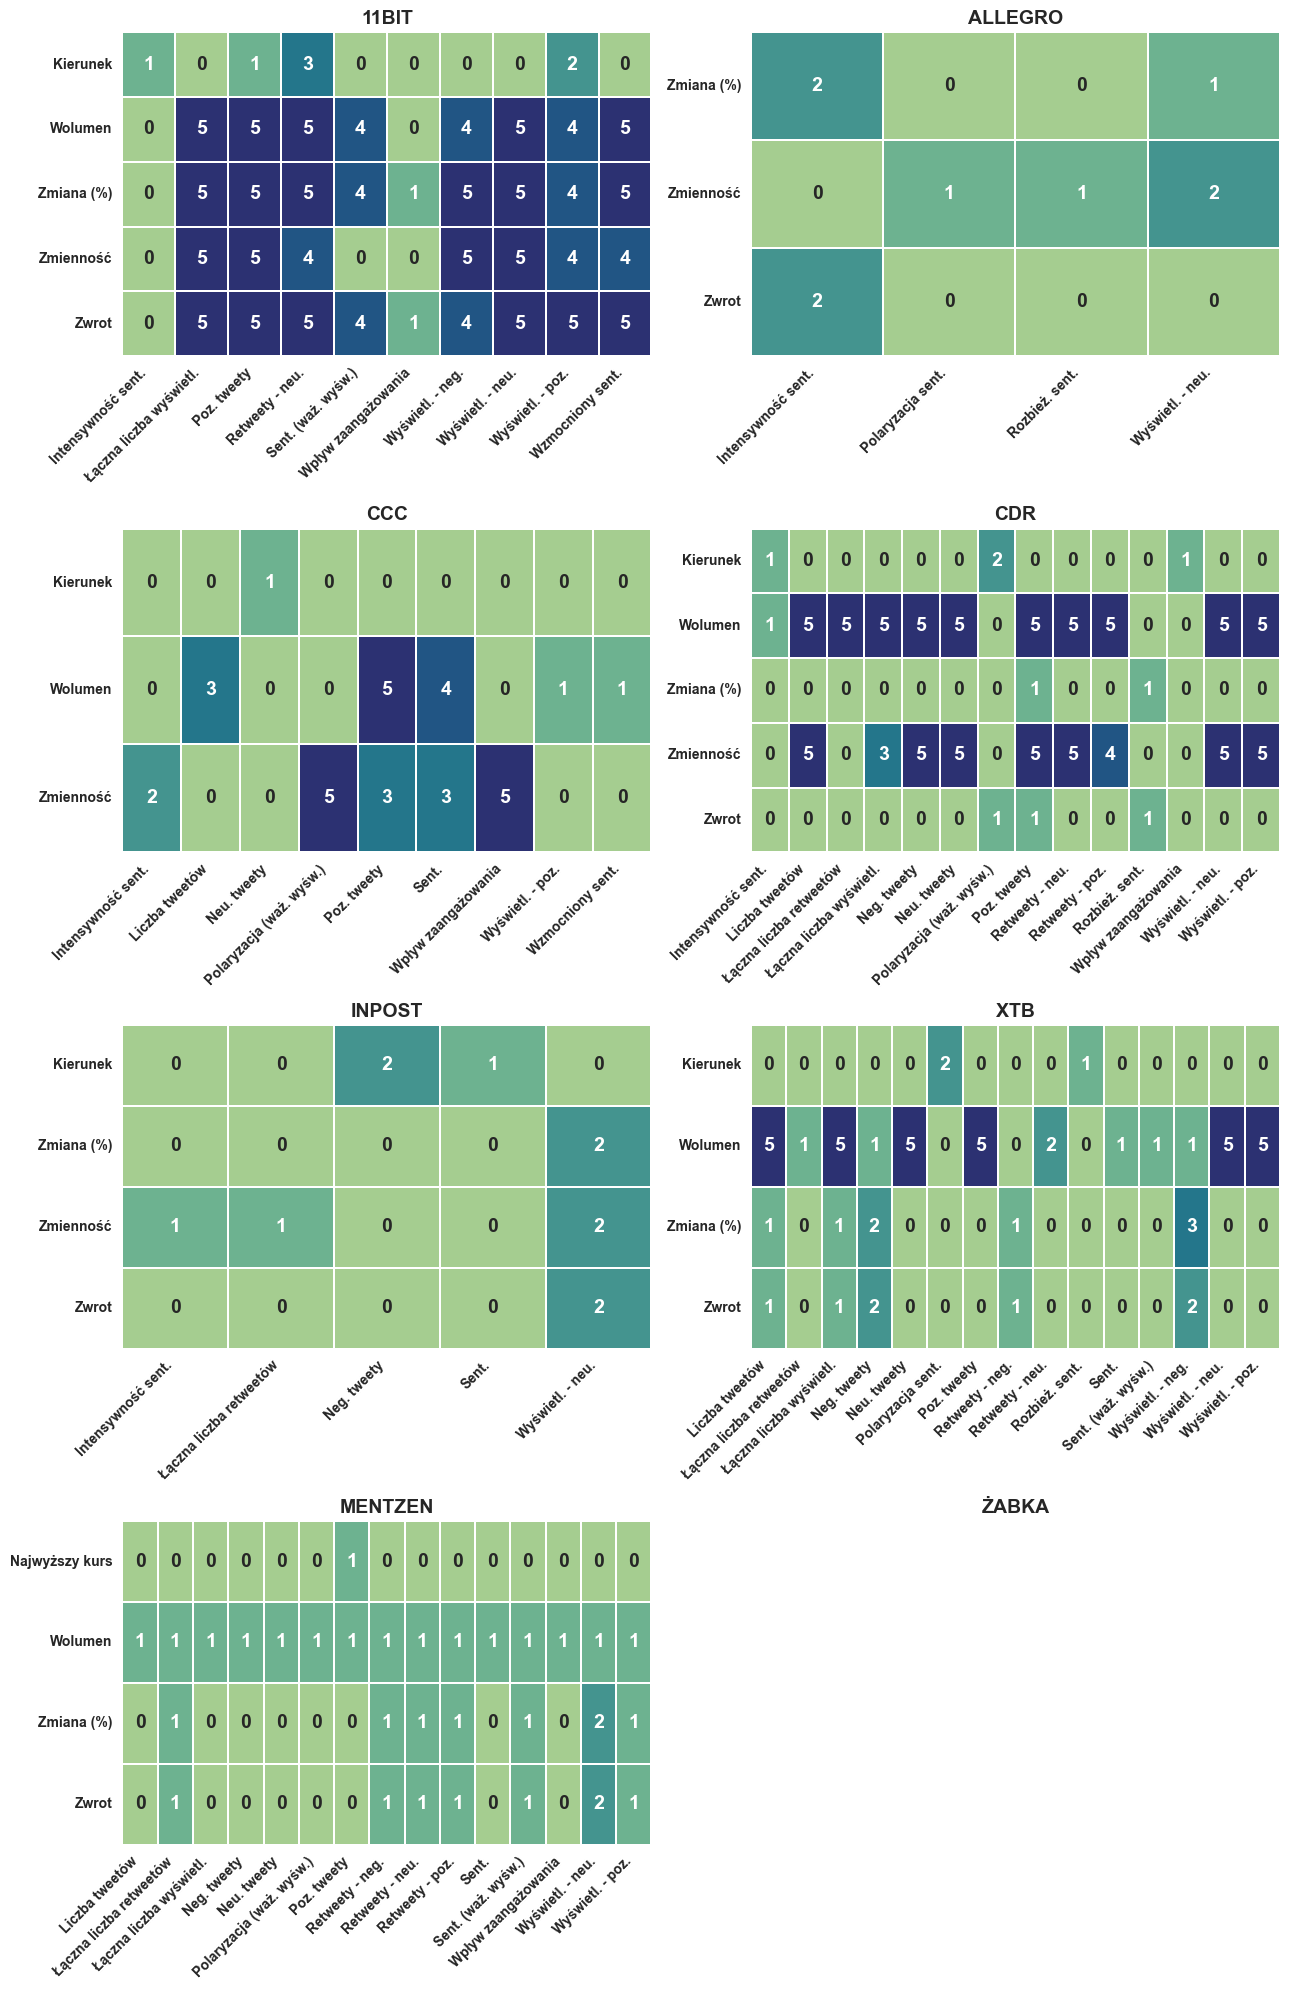

In [42]:
# Your df and column_labels_pl etc are assumed defined here
df['Zmienne Objaśniana'] = df['Target Variable'].replace(column_labels_pl)
df['Zmienne Objaśniające'] = df['Source Feature'].replace(column_labels_pl)
fix, axes = plt.subplots(nrows=4, ncols=2, figsize=(13, 20))
axes = axes.flatten()

# Find global max value across all pivot tables to unify scale
max_val = 0
pivot_tables = []

for company in companies:
    data = df[df['Company'] == company]
    data = data[data['Significant']==True]
    significant_df = data[data['Significant']]
    pivot_table = significant_df.pivot_table(
        index='Zmienne Objaśniana',
        columns='Zmienne Objaśniające',
        values='Lag',
        aggfunc='count',
        fill_value=0
    )

    all_targets = sorted(data['Zmienne Objaśniana'].unique(), key=locale.strxfrm)
    all_features = sorted(data['Zmienne Objaśniające'].unique(), key=locale.strxfrm)
    pivot_table = pivot_table.reindex(index=all_targets, columns=all_features, fill_value=0)
    
    pivot_tables.append(pivot_table)
    
    # Handle empty pivot tables
    if pivot_table.size > 0:
        max_val = max(max_val, pivot_table.values.max())

# Set minimum max_val to 1 if all pivot tables are empty
if max_val == 0:
    max_val = 1

# Plot with unified color scale and no colorbars individually
for i, company in enumerate(companies):
    ax = axes[i]
    pivot_table = pivot_tables[i]

    sns.heatmap(
        pivot_table,
        annot=True,
        fmt='d',
        cmap='crest',
        linewidths=0.1,
        linecolor='white',
        vmin=0,
        vmax=max_val,
        cbar=False,
        ax=ax,
        annot_kws={"fontsize": 14, "weight": "bold"}  
    )

    ax.set_title(company, fontsize=14, fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10, fontweight='bold')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right', fontsize=10, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

To used already implemented VAR funcionality a dataframe with no precomputed lagged has to be provided. Therefore, non trading days have to be handled somehow, so that simply removing them won't distort the relationships

In [43]:
pprint.pprint(stationary_columns)

{'11BIT': {'STOCK': ['Wolumen', 'Return', 'volatility', 'Direction', 'Change'],
           'TWITTER': ['Positive',
                       'view_count_Negative',
                       'view_count_Neutral',
                       'view_count_Positive',
                       'retweet_count_Neutral',
                       'sentiment_score_views',
                       'total_views',
                       'sentiment_polarity',
                       'view_weighted_polarity',
                       'sentiment_intensity',
                       'amplified_sentiment',
                       'sentiment_divergence',
                       'engagement_impact']},
 'ALLEGRO': {'STOCK': ['Wolumen',
                       'Return',
                       'volatility',
                       'Direction',
                       'Change'],
             'TWITTER': ['Negative',
                         'Neutral',
                         'Positive',
                         'view_count_Negative',
   

In [44]:
companies

['11BIT', 'ALLEGRO', 'CCC', 'CDR', 'INPOST', 'XTB', 'MENTZEN', 'ŻABKA']

In [46]:
def select_lags(stock_var, tweet_vars, max_lags=5):
    """Choose optimal lags via mutual information with stock variable"""
    mi_scores = {}
    for lag in range(1, max_lags+1):
        lagged_vars = [f"{var}_lag_{lag}" for var in tweet_vars]
        X = data[lagged_vars]
        mi = mutual_info_regression(X, data[stock_var])
        mi_scores[lag] = np.mean(mi)
        
    # Keep top 2 lags with highest MI
    best_lags = sorted(mi_scores, key=mi_scores.get, reverse=True)[:2]
    return [f"{var}_lag_{l}" for l in best_lags for var in tweet_vars]


In [ ]:

# Dictionary of variables to drop per company
columns_to_drop = {
    '11BIT': ['view_count_Neutral','engagement_impact'],
    'ALLEGRO': ['Neutral',''],
    'CCC': ['view_weighted_polarity'],
    'CDR': ['tweet_volume', 'view_weighted_polarity'],
    'INPOST': ['tweet_volume', 'view_weighted_polarity'],
    'XTB': ['tweet_volume', 'retweet_count_Positive', 'view_weighted_polarity'],
    'MENTZEN': ['view_count_Positive', 'retweet_count_Positive', 'sentiment_score_views',
                'retweet_count_Neutral', 'total_retweet_count', 'sentiment_intensity', 'view_weighted_polarity'],
    'ŻABKA': ['tweet_volume']
}
columns_to_drop

corr_per_company = {}
for company in companies:
    print(company)
    df = companies_data_daily_final_full[companies_data_daily_final_full['company'] == company]

    stationary_columns = [k for k,v in stationarity_results[company]['TWITTER'].items() if v]
    cols_to_drop = columns_to_drop.get(company, [])
    df_corr = df[stationary_columns].corr()
    df_corr.reset_index(inplace=True)
    df_corr_melted = pd.melt(df_corr,'index')

    df_corr_melted = df_corr_melted[~((df_corr_melted['index'].isin(cols_to_drop)) | (df_corr_melted['variable'].isin(cols_to_drop)))]
    corr_per_company[company] = df_corr_melted[(df_corr_melted['value']>=0.9) & (df_corr_melted['value']<1) ]
    pprint.pprint(corr_per_company[company])

11BIT
Empty DataFrame
Columns: [index, variable, value]
Index: []
ALLEGRO
                      index                variable     value
3       view_count_Negative                Negative  0.905395
6       total_retweet_count                Negative  0.917547
7    retweet_count_Negative                Negative  0.925026
10             tweet_volume                Negative  0.986590
60                 Negative     view_count_Negative  0.905395
66      total_retweet_count     view_count_Negative  0.914173
67   retweet_count_Negative     view_count_Negative  0.939460
120                Negative     total_retweet_count  0.917547
123     view_count_Negative     total_retweet_count  0.914173
127  retweet_count_Negative     total_retweet_count  0.973917
140                Negative  retweet_count_Negative  0.925026
143     view_count_Negative  retweet_count_Negative  0.939460
146     total_retweet_count  retweet_count_Negative  0.973917
200                Negative            tweet_volume  0.986

In [ ]:
df = companies_data_daily_final_full[companies_data_daily_final_full['company'] == company]
stationary_columns = 
stationary_columns_with_lags = [x for x in df.columns if x.startswith(tuple(stationary_columns))]


### Non - linear modelling

AUTOCORRELATION ORDER (for block bootstrap):
{'11BIT': {'STOCK': {'Change': 1,
                     'Direction': 20,
                     'Return': 1,
                     'Wolumen': 20,
                     'volatility': 20},
           'TWITTER': {'Positive': 20,
                       'amplified_sentiment': 1,
                       'engagement_impact': 19,
                       'retweet_count_Neutral': 20,
                       'sentiment_divergence': 1,
                       'sentiment_intensity': 3,
                       'sentiment_polarity': 12,
                       'sentiment_score_views': 3,
                       'total_views': 20,
                       'view_count_Negative': 20,
                       'view_count_Neutral': 20,
                       'view_count_Positive': 20,
                       'view_weighted_polarity': 1}},
 'ALLEGRO': {'STOCK': {'Change': 1,
                       'Direction': 1,
                       'Return': 1,
                       'Wolume

In [58]:
# Initialize results dictionaries
autocorrelation_results = {}
# Autocorrelation threshold
autocorr_p_threshold = 0.05  # p-value threshold for autocorrelation significance
max_lags = 10  # Maximum number of lags to test

# Check autocorrelation for each variable
for company in companies:
    STOCK = [k for k,v in stationarity_results[company]['STOCK'].items() if v]
    TWITTER = [k for k,v in stationarity_results[company]['TWITTER'].items() if v]
    autocorrelation_results[company] = {'STOCK': {}, 'TWITTER': {}}
    
    for variable in STOCK + TWITTER:
        # Extract data for the specific variable and company
        series = companies_data_daily_final_full[companies_data_daily_final_full['company'] == company][variable].dropna()
        
        # Skip if series is too short
        if len(series) <= max_lags:
            category = 'STOCK' if variable in STOCK else 'TWITTER'
            autocorrelation_results[company][category][variable] = False
            continue
        
        # Perform the Ljung-Box test for autocorrelation
        from statsmodels.stats.diagnostic import acorr_ljungbox
        result = acorr_ljungbox(series, lags=max_lags, return_df=True)
        
        # Check if any lag shows significant autocorrelation
        p_values = result['lb_pvalue']
        has_autocorrelation = any(p_values < autocorr_p_threshold)
        
        # Store whether the variable has significant autocorrelation
        category = 'STOCK' if variable in STOCK else 'TWITTER'
        autocorrelation_results[company][category][variable] = has_autocorrelation

pprint.pprint(autocorrelation_results)

{'11BIT': {'STOCK': {'Change': False,
                     'Direction': True,
                     'Return': False,
                     'Wolumen': True,
                     'volatility': True},
           'TWITTER': {'Positive': True,
                       'amplified_sentiment': False,
                       'engagement_impact': False,
                       'retweet_count_Neutral': True,
                       'sentiment_divergence': False,
                       'sentiment_intensity': True,
                       'sentiment_polarity': True,
                       'sentiment_score_views': True,
                       'total_views': True,
                       'view_count_Negative': True,
                       'view_count_Neutral': True,
                       'view_count_Positive': True,
                       'view_weighted_polarity': False}},
 'ALLEGRO': {'STOCK': {'Change': False,
                       'Direction': True,
                       'Return': False,
               

In [ ]:
tylko stacjonarne
nieliniowe modele + interpretowalne

mutual information
CGB model with shap

### GBM with shap

In [ ]:
import shap
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm, t
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
import warnings

In [106]:
company = 'CCC'
df = companies_data_daily_final_full[companies_data_daily_final_full['company'] == company]
stationary_columns = [k for k,v in stationarity_results[company]['TWITTER'].items() if v]
stationary_columns_STOCK = [k for k,v in stationarity_results[company]['STOCK'].items() if v]
stationary_columns_with_lags = [x for x in df.columns if x.startswith(tuple(stationary_columns))]

In [113]:
col = 'Negative'


1

In [120]:
flatten = {}
for res in results:
    flatten[res['Variable']] = res['Causal']

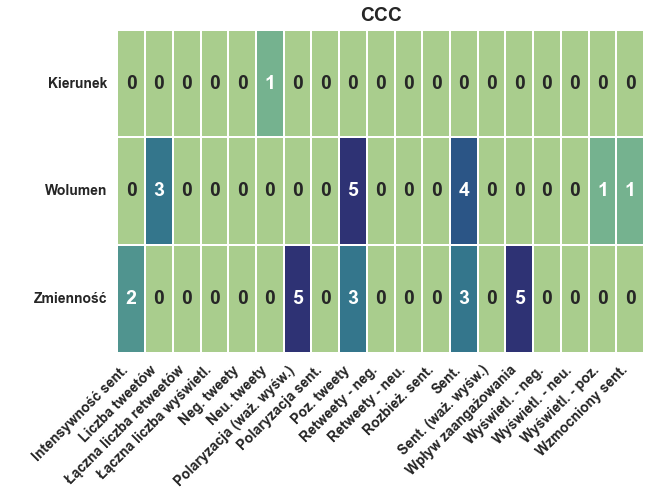

In [157]:
flatten

{'Negative': False,
 'Neutral': False,
 'Positive': False,
 'view_count_Negative': False,
 'view_count_Neutral': True,
 'view_count_Positive': False,
 'total_retweet_count': False,
 'retweet_count_Negative': False,
 'retweet_count_Neutral': True,
 'tweet_volume': False,
 'sentiment_score': False,
 'sentiment_score_views': False,
 'total_views': False,
 'sentiment_polarity': False,
 'view_weighted_polarity': True,
 'sentiment_intensity': True,
 'amplified_sentiment': False,
 'sentiment_divergence': False,
 'engagement_impact': False}

In [ ]:
result = test_granger_causality(
                    stock_col, 
                    twitter_base, 
                    df,
                    n_lags=5,
                    test_size=0.2,
                    n_bootstrap=100,  # Reduce for faster testing
                    block_size=5
                )

In [ ]:
(Y, X_base, df, n_lags=5, test_size=0.2, 
                          n_bootstrap=200, block_size=5):

In [ ]:
res = test_granger_causality(
        Y='Wolumen',
        X_base='sentiment_divergence',
        df=companies_data_daily_final_full[companies_data_daily_final_full['company'] == 'CCC'],
        n_lags=1,
        test_size=0.2,
        block_size= autocorrelation_results_ord['CCC']['TWITTER']['sentiment_divergence'],
        n_bootstrap=100
    )

sns.histplot(res['boostrap_stats'], kde=True)  # kde=True adds smooth curve
plt.title("Distribution of Data")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

Tuning hyperparameters for Wolumen <- sentiment_divergence...
Best params - Restricted: units=48, epochs=60
Best params - Unrestricted: units=48, epochs=60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Running 100 bootstraps...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━

In [ ]:
res = test_granger_causality(
        Y='Wolumen',
        X_base='tweet_volume',
        df=companies_data_daily_final_full[companies_data_daily_final_full['company'] == 'CCC'],
        n_lags=1,
        test_size=0.2,
        block_size= autocorrelation_results_ord['CCC']['TWITTER']['tweet_volume'],
        n_bootstrap=100
    )

sns.histplot(res['boostrap_stats'], kde=True)  # kde=True adds smooth curve
plt.title("Distribution of Data")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

Tuning hyperparameters for Wolumen <- tweet_volume...


In [168]:
res

{'Y': 'Wolumen',
 'X': 'sentiment_divergence',
 'd_bar': -221682.24866563446,
 'p_value': 0.9801980198019802,
 'causal': False,
 'units_res': 48,
 'epochs_res': 60,
 'units_unres': 48,
 'epochs_unres': 60,
 'bootstrap_mean': -139015.10084369077}

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# --------------------------
# Core Functions
# --------------------------



def tune_lstm_hyperparameters(X_train, y_train, input_shape):
    """Find optimal units and epochs using time-series cross-validation"""
    best_units = 32  # Default
    best_epochs = 100  # Default
    best_val_loss = float('inf')
    
    # Hyperparameter search space
    units_options = [16, 32, 48]
    epochs_options = [10, 30, 60]
    
    # Reduced CV for efficiency
    tscv = TimeSeriesSplit(n_splits=2)
    
    for units in units_options:
        for max_epochs in epochs_options:
            val_losses = []
            
            for train_idx, val_idx in tscv.split(X_train):
                # Split training/validation
                X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
                y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
                
                # Build model
                model = Sequential([
                    LSTM(units, input_shape=input_shape),
                    Dense(1)
                ])
                model.compile(optimizer='adam', loss='mse')
                
                # Train with early stopping
                early_stop = EarlyStopping(monitor='val_loss', 
                                          patience=5, 
                                          restore_best_weights=True,
                                          verbose=0)
                
                history = model.fit(
                    X_fold_train, y_fold_train,
                    validation_data=(X_fold_val, y_fold_val),
                    epochs=max_epochs,
                    batch_size=32,
                    callbacks=[early_stop],
                    verbose=0
                )
                
                # Track best validation loss
                val_losses.append(min(history.history['val_loss']))
            
            # Average validation loss across folds
            mean_val_loss = np.mean(val_losses)
            if mean_val_loss < best_val_loss:
                best_val_loss = mean_val_loss
                best_units = units
                best_epochs = max_epochs
    
    return best_units, best_epochs

def train_final_model(X_train, y_train, input_shape, units, epochs):
    """Train final model with optimal hyperparameters"""
    model = Sequential([
        LSTM(units, input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    
    # Early stopping on validation split
    early_stop = EarlyStopping(monitor='val_loss', 
                              patience=5, 
                              restore_best_weights=True,
                              verbose=0)
    
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=0
    )
    return model

def test_granger_causality(Y, X_base, df, n_lags=5, test_size=0.2, 
                          n_bootstrap=200, block_size=5):
    """
    Main Granger causality test function with:
    - Hyperparameter tuning
    - Block bootstrapping
    """
    # 1. Prepare data
    temp_df = pd.DataFrame(index=df.index)
    temp_df[Y] = df[Y]
    # Create Y lags
    for i in range(1, n_lags+1):
        temp_df[f'{Y}_lag_{i}'] = temp_df[Y].shift(i)
    
    # Identify X lags
    X_lags = [f'{X_base}_lag_{i}' for i in range(1, n_lags+1)]
    missing = [col for col in X_lags if col not in df.columns]
    if missing:
        print(f"Missing columns for {X_base}: {missing}")
        return None, None, False, None
    
    # Combine and clean
    data = pd.concat([temp_df, df[X_lags]], axis=1).dropna()
    y_data = data[Y].values
    Y_lag_cols = [f'{Y}_lag_{i}' for i in range(1, n_lags+1)]
    full_index = data.index
    
    # 2. Train-test split (time-based)
    n_test = int(len(data) * test_size)
    n_train = len(data) - n_test
    splits = {
        'train': slice(None, n_train),
        'test': slice(n_train, None)
    }
    
    # 3. Prepare feature sets
    # Restricted model (only Y lags)
    X_restricted = data[Y_lag_cols].values
    
    # Unrestricted model (Y and X lags)
    X_unrestricted = np.zeros((len(data), n_lags, 2))
    for i in range(len(data)):
        for j in range(n_lags):
            X_unrestricted[i, j, 0] = data[Y_lag_cols[j]].iloc[i]
            X_unrestricted[i, j, 1] = data[X_lags[j]].iloc[i]
    
    # Split data
    X_res_train, X_res_test = X_restricted[splits['train']], X_restricted[splits['test']]
    X_unres_train, X_unres_test = X_unrestricted[splits['train']], X_unrestricted[splits['test']]
    y_train, y_test = y_data[splits['train']], y_data[splits['test']]
    
    # 4. Scaling
    scaler_res = StandardScaler()
    X_res_train_scaled = scaler_res.fit_transform(X_res_train)
    X_res_test_scaled = scaler_res.transform(X_res_test)
    X_res_train_3d = X_res_train_scaled.reshape((-1, n_lags, 1))
    X_res_test_3d = X_res_test_scaled.reshape((-1, n_lags, 1))
    
    scaler_unres = StandardScaler()
    X_unres_train_2d = X_unres_train.reshape((-1, n_lags*2))
    X_unres_test_2d = X_unres_test.reshape((-1, n_lags*2))
    X_unres_train_scaled = scaler_unres.fit_transform(X_unres_train_2d)
    X_unres_test_scaled = scaler_unres.transform(X_unres_test_2d)
    X_unres_train_3d = X_unres_train_scaled.reshape((-1, n_lags, 2))
    X_unres_test_3d = X_unres_test_scaled.reshape((-1, n_lags, 2))
    
    # 5. Hyperparameter tuning
    print(f"Tuning hyperparameters for {Y} <- {X_base}...")
    units_res, epochs_res = tune_lstm_hyperparameters(
        X_res_train_3d, y_train, (n_lags, 1))
    units_unres, epochs_unres = tune_lstm_hyperparameters(
        X_unres_train_3d, y_train, (n_lags, 2))
    
    print(f"Best params - Restricted: units={units_res}, epochs={epochs_res}")
    print(f"Best params - Unrestricted: units={units_unres}, epochs={epochs_unres}")
    
    # 6. Train final models
    model_res = train_final_model(
        X_res_train_3d, y_train, (n_lags, 1), units_res, epochs_res)
    model_unres = train_final_model(
        X_unres_train_3d, y_train, (n_lags, 2), units_unres, epochs_unres)
    
    # 7. Original predictions
    pred_res = model_res.predict(X_res_test_3d).flatten()
    pred_unres = model_unres.predict(X_unres_test_3d).flatten()
    e_res = y_test - pred_res
    e_unres = y_test - pred_unres
    d_original = e_res**2 - e_unres**2
    d_bar_original = np.mean(d_original)
    
    # 8. Bootstrapping
    base_series = df.loc[full_index, X_base].copy()
    bootstrap_stats = []
    
    print(f"Running {n_bootstrap} bootstraps...")
    for b in range(n_bootstrap):
        if (b+1) % 50 == 0:
            print(f"  Bootstrap {b+1}/{n_bootstrap}")
        
        # Create shuffled X series
        shuffled_base = block_shuffle(base_series, block_size)
        
        # Create new lag features from shuffled series
        temp = pd.DataFrame(index=full_index)
        temp[X_base] = shuffled_base
        for i in range(1, n_lags+1):
            temp[f'{X_base}_lag_{i}'] = temp[X_base].shift(i)
        
        # Build new unrestricted dataset
        X_unrestricted_shuffled = np.zeros((len(data), n_lags, 2))
        for i in range(len(data)):
            for j in range(n_lags):
                X_unrestricted_shuffled[i, j, 0] = data[Y_lag_cols[j]].iloc[i]
                X_unrestricted_shuffled[i, j, 1] = temp[X_lags[j]].iloc[i]
        
        # Extract test portion
        X_unres_test_shuffled = X_unrestricted_shuffled[splits['test']]
        X_unres_test_shuffled_2d = X_unres_test_shuffled.reshape((-1, n_lags*2))
        X_unres_test_shuffled_scaled = scaler_unres.transform(X_unres_test_shuffled_2d)
        X_unres_test_shuffled_3d = X_unres_test_shuffled_scaled.reshape((-1, n_lags, 2))
        
        # Predict with shuffled X
        pred_unres_shuffled = model_unres.predict(X_unres_test_shuffled_3d).flatten()
        e_unres_shuffled = y_test - pred_unres_shuffled
        
        # Compute loss difference
        d_shuffled = e_res**2 - e_unres_shuffled**2
        d_bar_shuffled = np.mean(d_shuffled)
        bootstrap_stats.append(d_bar_shuffled)
    
    # 9. Calculate p-value
    bootstrap_stats = np.array(bootstrap_stats)
    p_value = (np.sum(bootstrap_stats >= d_bar_original) + 1) / (n_bootstrap + 1)
    causal = (d_bar_original > 0) and (p_value < 0.05)
    
    return {
        'Y': Y,
        'X': X_base,
        'd_bar': d_bar_original,
        'p_value': p_value,
        'causal': causal,
        'units_res': units_res,
        'epochs_res': epochs_res,
        'units_unres': units_unres,
        'epochs_unres': epochs_unres,
        'bootstrap_mean': np.mean(bootstrap_stats),
        'boostrap_stats':bootstrap_stats
    }

In [114]:
results = []
for col in stationary_columns:
    d_bar_original, p_value, causal, bootstrap_stats = test_granger_causality(
        Y='Wolumen',
        X_base='Positive',
        df=companies_data_daily_final_full[companies_data_daily_final_full['company'] == 'CCC'],
        n_lags=1,
        test_size=0.2,
        epochs=60,
        units=48,
        block_size= autocorrelation_results_ord['CCC']['TWITTER'][col],
        n_bootstrap=300
    )
    results.append({
        'Variable': col,
        'd_bar_original': d_bar_original,
        'p_value': p_value,
        'Causal': causal,
        'Bootstrap Stats': bootstrap_stats
    })

e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Running 300 bootstrap iterations...
Bootstrap iteration 50/300
Bootstrap iteration 100/300
Bootstrap iteration 150/300
Bootstrap iteration 200/300
Bootstrap iteration 250/300
Bootstrap iteration 300/300


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Running 300 bootstrap iterations...
Bootstrap iteration 50/300
Bootstrap iteration 100/300
Bootstrap iteration 150/300
Bootstrap iteration 200/300
Bootstrap iteration 250/300
Bootstrap iteration 300/300


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Running 300 bootstrap iterations...
Bootstrap iteration 50/300
Bootstrap iteration 100/300
Bootstrap iteration 150/300
Bootstrap iteration 200/300
Bootstrap iteration 250/300
Bootstrap iteration 300/300


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Running 300 bootstrap iterations...
Bootstrap iteration 50/300
Bootstrap iteration 100/300
Bootstrap iteration 150/300
Bootstrap iteration 200/300
Bootstrap iteration 250/300
Bootstrap iteration 300/300


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Running 300 bootstrap iterations...
Bootstrap iteration 50/300
Bootstrap iteration 100/300
Bootstrap iteration 150/300
Bootstrap iteration 200/300
Bootstrap iteration 250/300
Bootstrap iteration 300/300


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Running 300 bootstrap iterations...
Bootstrap iteration 50/300
Bootstrap iteration 100/300
Bootstrap iteration 150/300
Bootstrap iteration 200/300
Bootstrap iteration 250/300
Bootstrap iteration 300/300


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Running 300 bootstrap iterations...
Bootstrap iteration 50/300
Bootstrap iteration 100/300
Bootstrap iteration 150/300
Bootstrap iteration 200/300
Bootstrap iteration 250/300
Bootstrap iteration 300/300


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Running 300 bootstrap iterations...
Bootstrap iteration 50/300
Bootstrap iteration 100/300
Bootstrap iteration 150/300
Bootstrap iteration 200/300
Bootstrap iteration 250/300
Bootstrap iteration 300/300


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Running 300 bootstrap iterations...
Bootstrap iteration 50/300
Bootstrap iteration 100/300
Bootstrap iteration 150/300
Bootstrap iteration 200/300
Bootstrap iteration 250/300
Bootstrap iteration 300/300


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Running 300 bootstrap iterations...
Bootstrap iteration 50/300
Bootstrap iteration 100/300
Bootstrap iteration 150/300
Bootstrap iteration 200/300
Bootstrap iteration 250/300
Bootstrap iteration 300/300


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Running 300 bootstrap iterations...
Bootstrap iteration 50/300
Bootstrap iteration 100/300
Bootstrap iteration 150/300
Bootstrap iteration 200/300
Bootstrap iteration 250/300
Bootstrap iteration 300/300


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Running 300 bootstrap iterations...
Bootstrap iteration 50/300
Bootstrap iteration 100/300
Bootstrap iteration 150/300
Bootstrap iteration 200/300
Bootstrap iteration 250/300
Bootstrap iteration 300/300


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Running 300 bootstrap iterations...
Bootstrap iteration 50/300
Bootstrap iteration 100/300
Bootstrap iteration 150/300
Bootstrap iteration 200/300
Bootstrap iteration 250/300
Bootstrap iteration 300/300


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Running 300 bootstrap iterations...
Bootstrap iteration 50/300
Bootstrap iteration 100/300
Bootstrap iteration 150/300
Bootstrap iteration 200/300
Bootstrap iteration 250/300
Bootstrap iteration 300/300


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Running 300 bootstrap iterations...
Bootstrap iteration 50/300
Bootstrap iteration 100/300
Bootstrap iteration 150/300
Bootstrap iteration 200/300
Bootstrap iteration 250/300
Bootstrap iteration 300/300


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Running 300 bootstrap iterations...
Bootstrap iteration 50/300
Bootstrap iteration 100/300
Bootstrap iteration 150/300
Bootstrap iteration 200/300
Bootstrap iteration 250/300
Bootstrap iteration 300/300


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Running 300 bootstrap iterations...
Bootstrap iteration 50/300
Bootstrap iteration 100/300
Bootstrap iteration 150/300
Bootstrap iteration 200/300
Bootstrap iteration 250/300
Bootstrap iteration 300/300


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Running 300 bootstrap iterations...
Bootstrap iteration 50/300
Bootstrap iteration 100/300
Bootstrap iteration 150/300
Bootstrap iteration 200/300
Bootstrap iteration 250/300
Bootstrap iteration 300/300


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Running 300 bootstrap iterations...
Bootstrap iteration 50/300
Bootstrap iteration 100/300
Bootstrap iteration 150/300
Bootstrap iteration 200/300
Bootstrap iteration 250/300
Bootstrap iteration 300/300


In [66]:
# Example usage and helper functions
def extract_base_features(twitter_columns, n_lags=5):
    """Extract base feature names from lagged columns."""
    base_features = set()
    for col in twitter_columns:
        base_col = col
        for i in range(1, n_lags + 1):
            base_col = base_col.replace(f'_lag_{i}', '')
        base_features.add(base_col)
    return list(base_features)

In [ ]:


def block_shuffle(series, block_size):
    """Shuffle blocks of a time series while preserving internal structure."""
    n = len(series)
    n_blocks = n // block_size
    blocks = [series[i*block_size:(i+1)*block_size].values for i in range(n_blocks)]
    
    # Handle remainder if exists
    remainder = n % block_size
    if remainder > 0:
        blocks.append(series[n_blocks*block_size:].values)
    
    np.random.shuffle(blocks)
    # Maintain original index structure
    shuffled_values = np.concatenate(blocks)
    return pd.Series(shuffled_values, index=series.index[:len(shuffled_values)])

def test_granger_causality(Y, X_base, df, n_lags=5, test_size=0.2, 
                           epochs=30, units=30, n_bootstrap=200, block_size=30):
    """
    Test Granger causality using LSTM neural networks with block bootstrapping.
    
    Parameters:
    - Y: Target variable (string)
    - X_base: Base predictor variable (string) 
    - df: DataFrame containing all variables and their lags
    - n_lags: Number of lags to use
    - test_size: Proportion of data for testing
    - epochs: Number of training epochs for LSTM
    - units: Number of LSTM units
    - n_bootstrap: Number of bootstrap iterations
    - block_size: Size of blocks for block bootstrapping
    
    Returns:
    - d_bar_original: Original test statistic
    - p_value: Bootstrap p-value
    - causal: Boolean indicating significant causality
    - bootstrap_stats: Array of bootstrap statistics
    """
    
    # Validate inputs
    if Y not in df.columns:
        raise ValueError(f"Target variable '{Y}' not found in DataFrame")
    if X_base not in df.columns:
        raise ValueError(f"Base predictor '{X_base}' not found in DataFrame")
    
    # Create lags for Y if they don't exist
    temp_df = pd.DataFrame(index=df.index)
    temp_df[Y] = df[Y]
    for i in range(1, n_lags+1):
        temp_df[f'{Y}_lag_{i}'] = temp_df[Y].shift(i)
    
    # Identify lag columns for X_base
    X_lags = [f'{X_base}_lag_{i}' for i in range(1, n_lags+1)]
    missing = [col for col in X_lags if col not in df.columns]
    if missing:
        print(f"Missing lag columns for {X_base}: {missing}")
        return None, None, False, None
    
    # Combine data and drop NA
    data = pd.concat([temp_df, df[X_lags]], axis=1).dropna()
    
    if len(data) < 50:  # Minimum data requirement
        print(f"Insufficient data after removing NAs: {len(data)} rows")
        return None, None, False, None
    
    y_data = data[Y].values
    Y_lag_cols = [f'{Y}_lag_{i}' for i in range(1, n_lags+1)]
    full_index = data.index
    
    # Time-based train-test split
    n_test = max(1, int(len(data) * test_size))  # Ensure at least 1 test sample
    n_train = len(data) - n_test
    
    if n_train < 10:  # Minimum training requirement
        print(f"Insufficient training data: {n_train} samples")
        return None, None, False, None
    
    # Build datasets
    X_restricted = data[Y_lag_cols].values
    X_unrestricted = np.zeros((len(data), n_lags, 2))
    
    for i in range(len(data)):
        for j in range(n_lags):
            X_unrestricted[i, j, 0] = data[Y_lag_cols[j]].iloc[i]
            X_unrestricted[i, j, 1] = data[X_lags[j]].iloc[i]
    
    # Split data
    X_res_train, X_res_test = X_restricted[:n_train], X_restricted[n_train:]
    X_unres_train, X_unres_test = X_unrestricted[:n_train], X_unrestricted[n_train:]
    y_train, y_test = y_data[:n_train], y_data[n_train:]
    
    # Scaling
    scaler_res = StandardScaler()
    X_res_train_scaled = scaler_res.fit_transform(X_res_train)
    X_res_test_scaled = scaler_res.transform(X_res_test)
    X_res_train_3d = X_res_train_scaled.reshape((-1, n_lags, 1))
    X_res_test_3d = X_res_test_scaled.reshape((-1, n_lags, 1))
    
    scaler_unres = StandardScaler()
    X_unres_train_2d = X_unres_train.reshape((-1, n_lags*2))
    X_unres_test_2d = X_unres_test.reshape((-1, n_lags*2))
    X_unres_train_scaled = scaler_unres.fit_transform(X_unres_train_2d)
    X_unres_test_scaled = scaler_unres.transform(X_unres_test_2d)
    X_unres_train_3d = X_unres_train_scaled.reshape((-1, n_lags, 2))
    X_unres_test_3d = X_unres_test_scaled.reshape((-1, n_lags, 2))
    
    # Model building function
    def build_model(input_shape):
        model = Sequential([
            LSTM(units, input_shape=input_shape, return_sequences=False),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        return model
    
    # Train original models with error handling
    try:
        model_res = build_model((n_lags, 1))
        model_unres = build_model((n_lags, 2))
        
        # Suppress verbose output
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model_res.fit(X_res_train_3d, y_train, epochs=epochs, batch_size=min(32, len(y_train)//2), verbose=0)
            model_unres.fit(X_unres_train_3d, y_train, epochs=epochs, batch_size=min(32, len(y_train)//2), verbose=0)
        
    except Exception as e:
        print(f"Error training models: {str(e)}")
        return None, None, False, None
    
    # Original predictions and errors
    try:
        pred_res = model_res.predict(X_res_test_3d, verbose=0).flatten()
        pred_unres = model_unres.predict(X_unres_test_3d, verbose=0).flatten()
    except Exception as e:
        print(f"Error making predictions: {str(e)}")
        return None, None, False, None
    
    e_res = y_test - pred_res
    e_unres = y_test - pred_unres
    d_original = e_res**2 - e_unres**2
    d_bar_original = np.mean(d_original)
    
    # Prepare for bootstrapping
    base_series = df.loc[full_index, X_base].copy()
    bootstrap_stats = []
    
    print(f"Running {n_bootstrap} bootstrap iterations...")
    
    for i in range(n_bootstrap):
        if (i + 1) % 50 == 0:
            print(f"Bootstrap iteration {i + 1}/{n_bootstrap}")
        
        try:
            # Create shuffled X series with block bootstrapping
            shuffled_base = block_shuffle(base_series, block_size)
            
            # Create new lag features from shuffled series
            temp = pd.DataFrame(index=full_index)
            temp[X_base] = shuffled_base
            for j in range(1, n_lags+1):
                temp[f'{X_base}_lag_{j}'] = temp[X_base].shift(j)
            
            # Build new unrestricted dataset
            X_unrestricted_shuffled = np.zeros((len(data), n_lags, 2))
            for k in range(len(data)):
                for j in range(n_lags):
                    X_unrestricted_shuffled[k, j, 0] = data[Y_lag_cols[j]].iloc[k]
                    # Handle potential NaN values from shifted data
                    lag_val = temp[X_lags[j]].iloc[k] if k < len(temp) else 0
                    X_unrestricted_shuffled[k, j, 1] = lag_val if not pd.isna(lag_val) else 0
            
            # Extract test portion and scale
            X_unres_test_shuffled = X_unrestricted_shuffled[n_train:]
            X_unres_test_shuffled_2d = X_unres_test_shuffled.reshape((-1, n_lags*2))
            X_unres_test_shuffled_scaled = scaler_unres.transform(X_unres_test_shuffled_2d)
            X_unres_test_shuffled_3d = X_unres_test_shuffled_scaled.reshape((-1, n_lags, 2))
            
            # Predict with shuffled X
            pred_unres_shuffled = model_unres.predict(X_unres_test_shuffled_3d, verbose=0).flatten()
            e_unres_shuffled = y_test - pred_unres_shuffled
            
            # Compute loss difference
            d_shuffled = e_res**2 - e_unres_shuffled**2
            d_bar_shuffled = np.mean(d_shuffled)
            bootstrap_stats.append(d_bar_shuffled)
            
        except Exception as e:
            print(f"Error in bootstrap iteration {i}: {str(e)}")
            # Use a neutral value for failed iterations
            bootstrap_stats.append(0.0)
    
    # Calculate bootstrap p-value
    bootstrap_stats = np.array(bootstrap_stats)
    valid_stats = bootstrap_stats[~np.isnan(bootstrap_stats)]
    
    if len(valid_stats) < n_bootstrap * 0.5:  # If more than half failed
        print(f"Too many bootstrap failures: {n_bootstrap - len(valid_stats)}/{n_bootstrap}")
        return d_bar_original, None, False, bootstrap_stats
    
    # Conservative p-value calculation
    p_value = (np.sum(valid_stats >= d_bar_original) + 1) / (len(valid_stats) + 1)
    causal = (d_bar_original > 0) and (p_value < 0.05)
    
    return d_bar_original, p_value, causal, bootstrap_stats



In [52]:
company = 'CCC'
df = companies_data_daily_final_full[companies_data_daily_final_full['company'] == company]
stationary_columns = [k for k,v in stationarity_results[company]['TWITTER'].items() if v]
stationary_columns_STOCK = [k for k,v in stationarity_results[company]['STOCK'].items() if v]
stationary_columns_with_lags = [x for x in df.columns if x.startswith(tuple(stationary_columns))]


lstm_result = {}
for company in companies:
    lstm_result[company] = {}
    stationary_columns = [k for k,v in stationarity_results[company]['TWITTER'].items() if v]
    stationary_columns_STOCK = [k for k,v in stationarity_results[company]['STOCK'].items() if v]
    df = companies_data_daily_final_full[companies_data_daily_final_full['company'] == company]
    
    for stock_col in stationary_columns_STOCK:
        lstm_result[company][stock_col] = {}
        
        for twitter_var in stationary_columns_with_lags:
           
            model_results = test_model_metrics(df=df,tweet_cols=[twitter_var],stock_col=[stock_col],company=company)
            lstm_result[company][stock_col][twitter_var] = model_results


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002924DA55AB0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


e:\Project_clean\PolishTweetsClassification\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyboardInterrupt: 

ADD CLASSIFICATION

In [ ]:
def evaluate_lookbacks(df, tweet_cols, stock_cols, lookbacks=[1]):
    results = {}
    
    for lookback in lookbacks:
        X, y, scaler_y = prepare_data(df, tweet_cols, stock_cols, lookback)
        
        # Train/test split
        split = int(0.8 * len(X))
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]
        
        # Create and train model
        model = create_model((lookback, len(tweet_cols)), len(stock_cols))
        history = model.fit(X_train, y_train, epochs=50, batch_size=32, 
                          validation_split=0.1, verbose=0)
        
        # Evaluate
        predictions = model.predict(X_test)
        predictions = scaler_y.inverse_transform(predictions)
        true_values = scaler_y.inverse_transform(y_test)
        
        mse = np.mean((predictions - true_values) ** 2)
        results[lookback] = {
            'mse': mse,
            'val_loss': min(history.history['val_loss'])
        }
    
    return results



In [ ]:
def create_rolling_predictions(df, tweet_cols, stock_cols, test_days=100, lookback=7):
   # Split into train and test
   train_df = df[:-test_days]
   test_df = df[-test_days:]
   
   predictions = []
   
   for i in range(len(test_df)):
       # Get updated training data including latest actual values
       current_train = pd.concat([train_df, test_df[:i]])
       
       # Prepare data
       X, y, scaler_y = prepare_data(current_train, tweet_cols, stock_cols, lookback)
       
       # Train model
       model = create_model((lookback, len(tweet_cols)), len(stock_cols))
       model.fit(X, y, epochs=50, batch_size=32, verbose=0)
       
       # Predict next day
       last_sequence = scaler_X.transform(current_train[tweet_cols].tail(lookback))
       pred = model.predict(last_sequence.reshape(1, lookback, -1))
       pred = scaler_y.inverse_transform(pred)[0]
       predictions.append(pred)
   
   return np.array(predictions)

predictions = create_rolling_predictions(df, tweet_columns, stock_columns)

In [ ]:
results = evaluate_lookbacks(merged_daily, tweet_columns, stock_columns)